In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings
import math
import seaborn as sns
import pickle

from gwpopulation.models.redshift import PowerLawRedshift
import deepdish as dd

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
from scipy.optimize import curve_fit

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
sys.path.append(os.getcwd() + '/Scripts')
from pickle_writers import pickle_rates_and_boostraps
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects
import formation_channels

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
# plt.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['font.sans-serif'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'stix'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_10550/430235574.py:49: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Get paths for the data files in the $\sigma$ and remnant mass prescription grid

In [2]:
velocity_dispersions = ['30', '265', '750'] # All the alpha values
remnant_mass_ps = ['D', 'M', 'R'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for velocity_dispersion in velocity_dispersions:
    condensed_paths[velocity_dispersion] = {}
    for remnant_mass_p in remnant_mass_ps:
        condensed_paths[velocity_dispersion][remnant_mass_p] = '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_sigma_remnant_prescription/output_sigma_'+velocity_dispersion+'_remnant_prescription_'+remnant_mass_p+'/COMPAS_Output_Weighted.h5'

# Merger Rates $R(z)$

Define parameters for the merger rate calculation

In [3]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = 'mixture_weight'
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 * (1 + max_redshift_detection)
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
num_colors = len(velocity_dispersions)*len(remnant_mass_ps)
counter = 0
color_grid = {}
for velocity_dispersion in velocity_dispersions:
    color_grid[velocity_dispersion] = {}
    for remnant_mass_p in remnant_mass_ps:
        color_grid[velocity_dispersion][remnant_mass_p] = rainbow_cmap(counter/num_colors)
        counter+=1

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

# MY FIDUCIAL MSSFR PRESCRIPTIONS
lognormal=False                                     # !!! IF THIS PARAMETER IS FALSE, IT WILL USE THE NON-LOGNORMAL MSSFR PRESCRIPTIONS !!!
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None

## Function used to calculate and plot the merger rates

In [4]:
def plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100):                                               # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
            with open('/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_sigma_remnant_prescription/output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(3, 2, figsize=(20, 30))

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['R']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            axes[0,0].plot(redshifts[alpha_val][beta_val], total_formation_rates[alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val])
            axes[0,0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0,0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            axes[0,1].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val + r'$\textrm{ RMP} = $' + beta_val, color=color_grid[alpha_val][beta_val])
            axes[0,1].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0,1].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            formation_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1,0].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val] / formation_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val])
            axes[1,0].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_formation_rates'][0] / formation_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_formation_rates'][1] / formation_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1,0].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_formation_rates'][0] / formation_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_formation_rates'][1] / formation_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1,1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val])
            axes[1,1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1,1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

            axes[2,0].plot(redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], cumulative_detection_rates[alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val])
            axes[2,0].fill_between(x=redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], y1=one_sigma[alpha_val][beta_val]['cumulative_detection_rates'][0], y2=one_sigma[alpha_val][beta_val]['cumulative_detection_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[2,0].fill_between(x=redshifts[alpha_val][beta_val][:len(cumulative_detection_rates[alpha_val][beta_val])], y1=two_sigma[alpha_val][beta_val]['cumulative_detection_rates'][0], y2=two_sigma[alpha_val][beta_val]['cumulative_detection_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            axis = np.arange(Mc_bins[alpha_val][beta_val][0],Mc_bins[alpha_val][beta_val][-1],0.1) # The x-axis for the chirp masses
            axes[2,1].plot(axis, mass_kde_scaled[alpha_val][beta_val], lw=lw, color=color_grid[alpha_val][beta_val])
            axes[2,1].fill_between(x=axis, y1=one_sigma[alpha_val][beta_val]['mass_kde'][0], y2=one_sigma[alpha_val][beta_val]['mass_kde'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[2,1].fill_between(x=axis, y1=two_sigma[alpha_val][beta_val]['mass_kde'][0], y2=two_sigma[alpha_val][beta_val]['mass_kde'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
        
    
    # Label axes of all the plots
    axes[0,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0,0].set_ylabel(r'\textbf{Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0,0].set_yscale('log')

    axes[0,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0,1].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0,1].set_yscale('log')

    axes[1,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1,0].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1,0].set_yscale('log')

    axes[1,1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1,1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1,1].set_yscale('log')

    axes[2,0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[2,0].set_ylabel(r'\textbf{Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$}', fontsize=fs)

    axes[2,1].set_xlabel(r'\textbf{Chirp mass, $\mathcal{M}_c$}', fontsize=fs)
    axes[2,1].set_ylabel(r'\textbf{Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$}', fontsize=fs)

    # Set upper limit on x axis for chirp mass distribution
    xlims = axes[2,1].get_xlim()
    if xlims[1] >= 40:
            axes[2,1].set_xlim([xlims[0], 40])

    # Set lower bound for merger rate divided by SFR
    ylims = axes[1,1].get_ylim()
    axes[1,1].set_ylim([10**-1.5, ylims[1]])

    # Set lower bounds for the plots
    ylims01 = axes[0,1].get_ylim()
    ylims11 = axes[1,1].get_ylim()
    axes[0,1].set_ylim([10**-1.5, ylims01[1]])
    axes[1,1].set_ylim([10**-2, ylims11[1]])

    for ax in axes.flatten():
            ax.tick_params(labelsize=0.9*fs)
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    form_const, merger_const = axes[0,0].get_ylim()[1] * 0.1, axes[0,1].get_ylim()[1] * 0.1

    # Plot SFRs
    axes[0,0].plot(sfr_redshifts, sfr * form_const, color='black', lw=3, linestyle='dashed')
    axes[0,1].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3, linestyle='dashed', label=r'SFR')

    # Plot horizontal line for SFR on the normalized plots
    axes[1,0].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1,1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.9*fs)

    # Include legend
    leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.9, .9525),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    # Show the plot!
    plt.show()

## a) BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


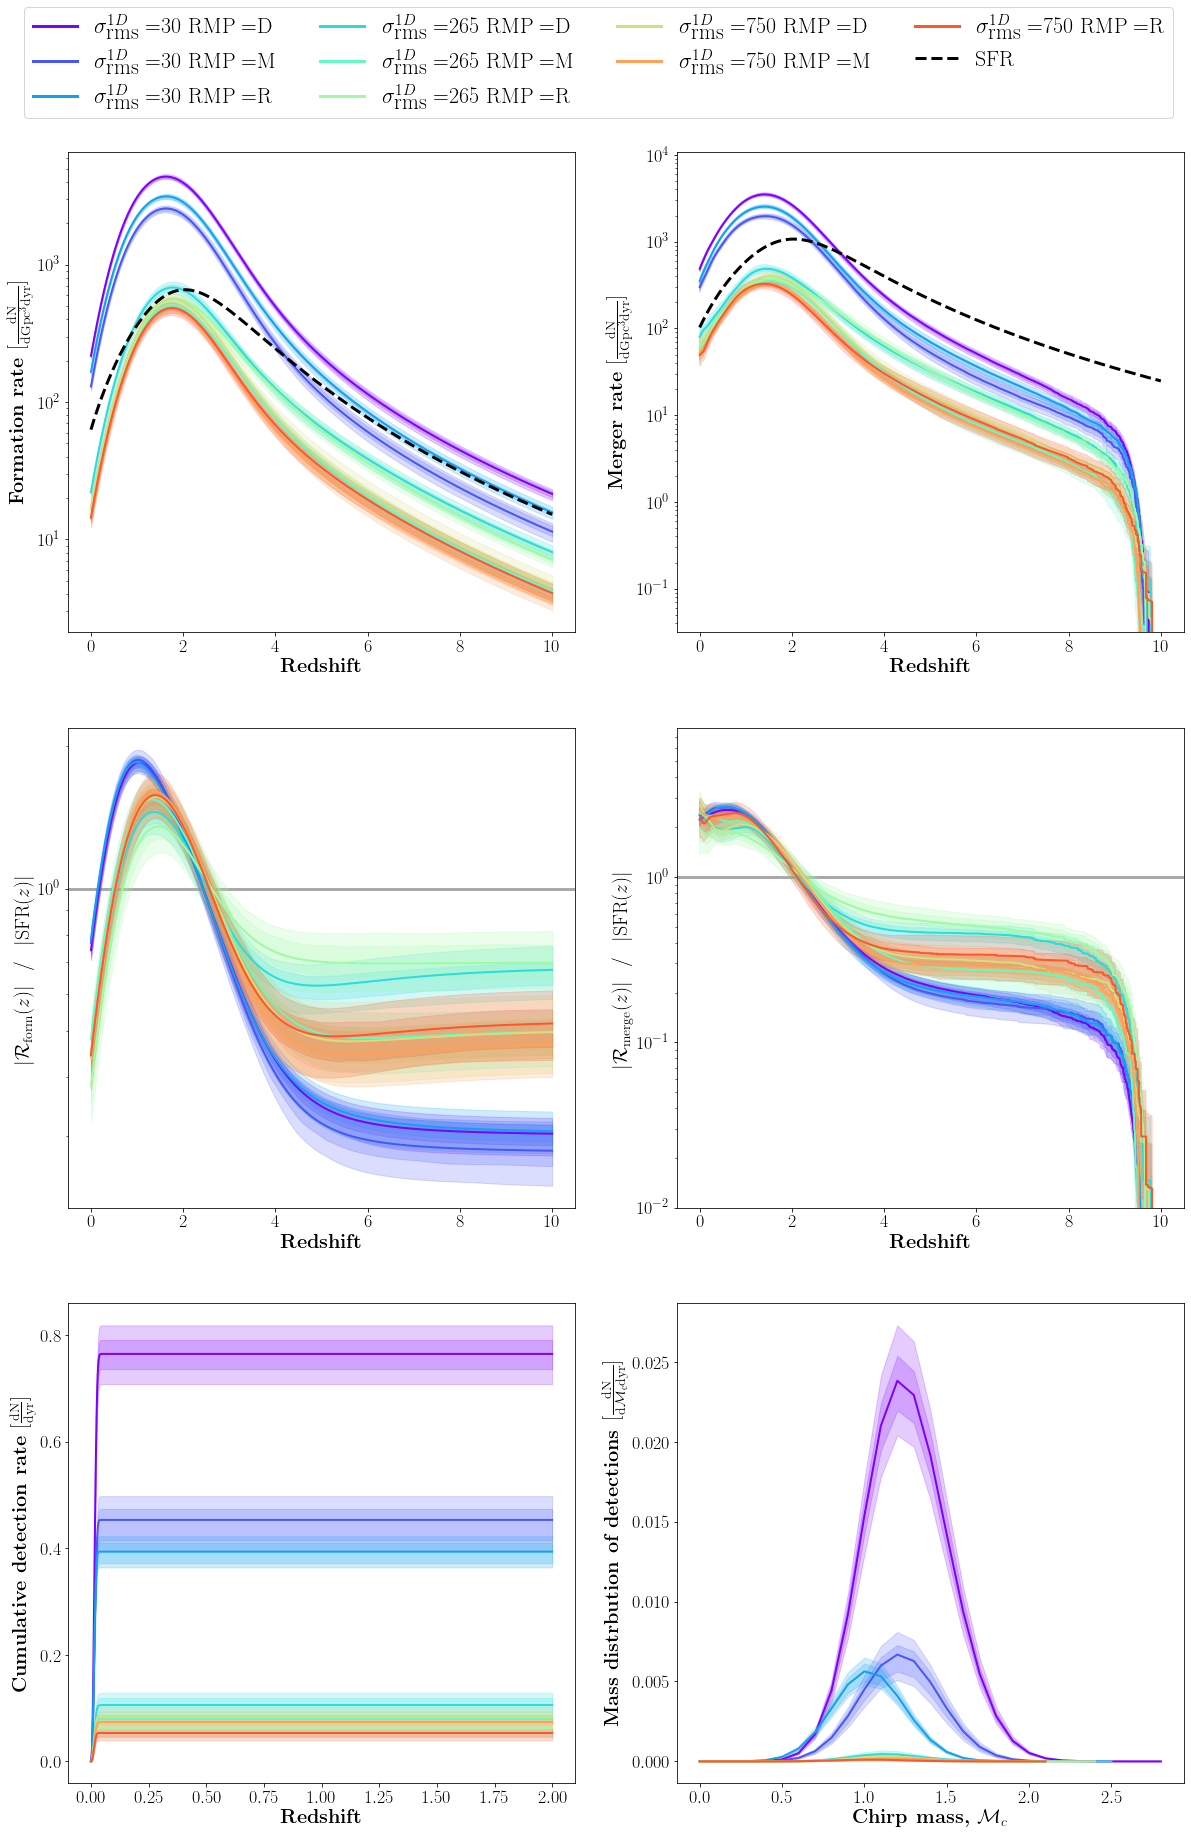

In [5]:
plot_pickled_rates_sfr_norm(condensed_paths, velocity_dispersions, remnant_mass_ps, dco_type='BNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100)                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS

## b) BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


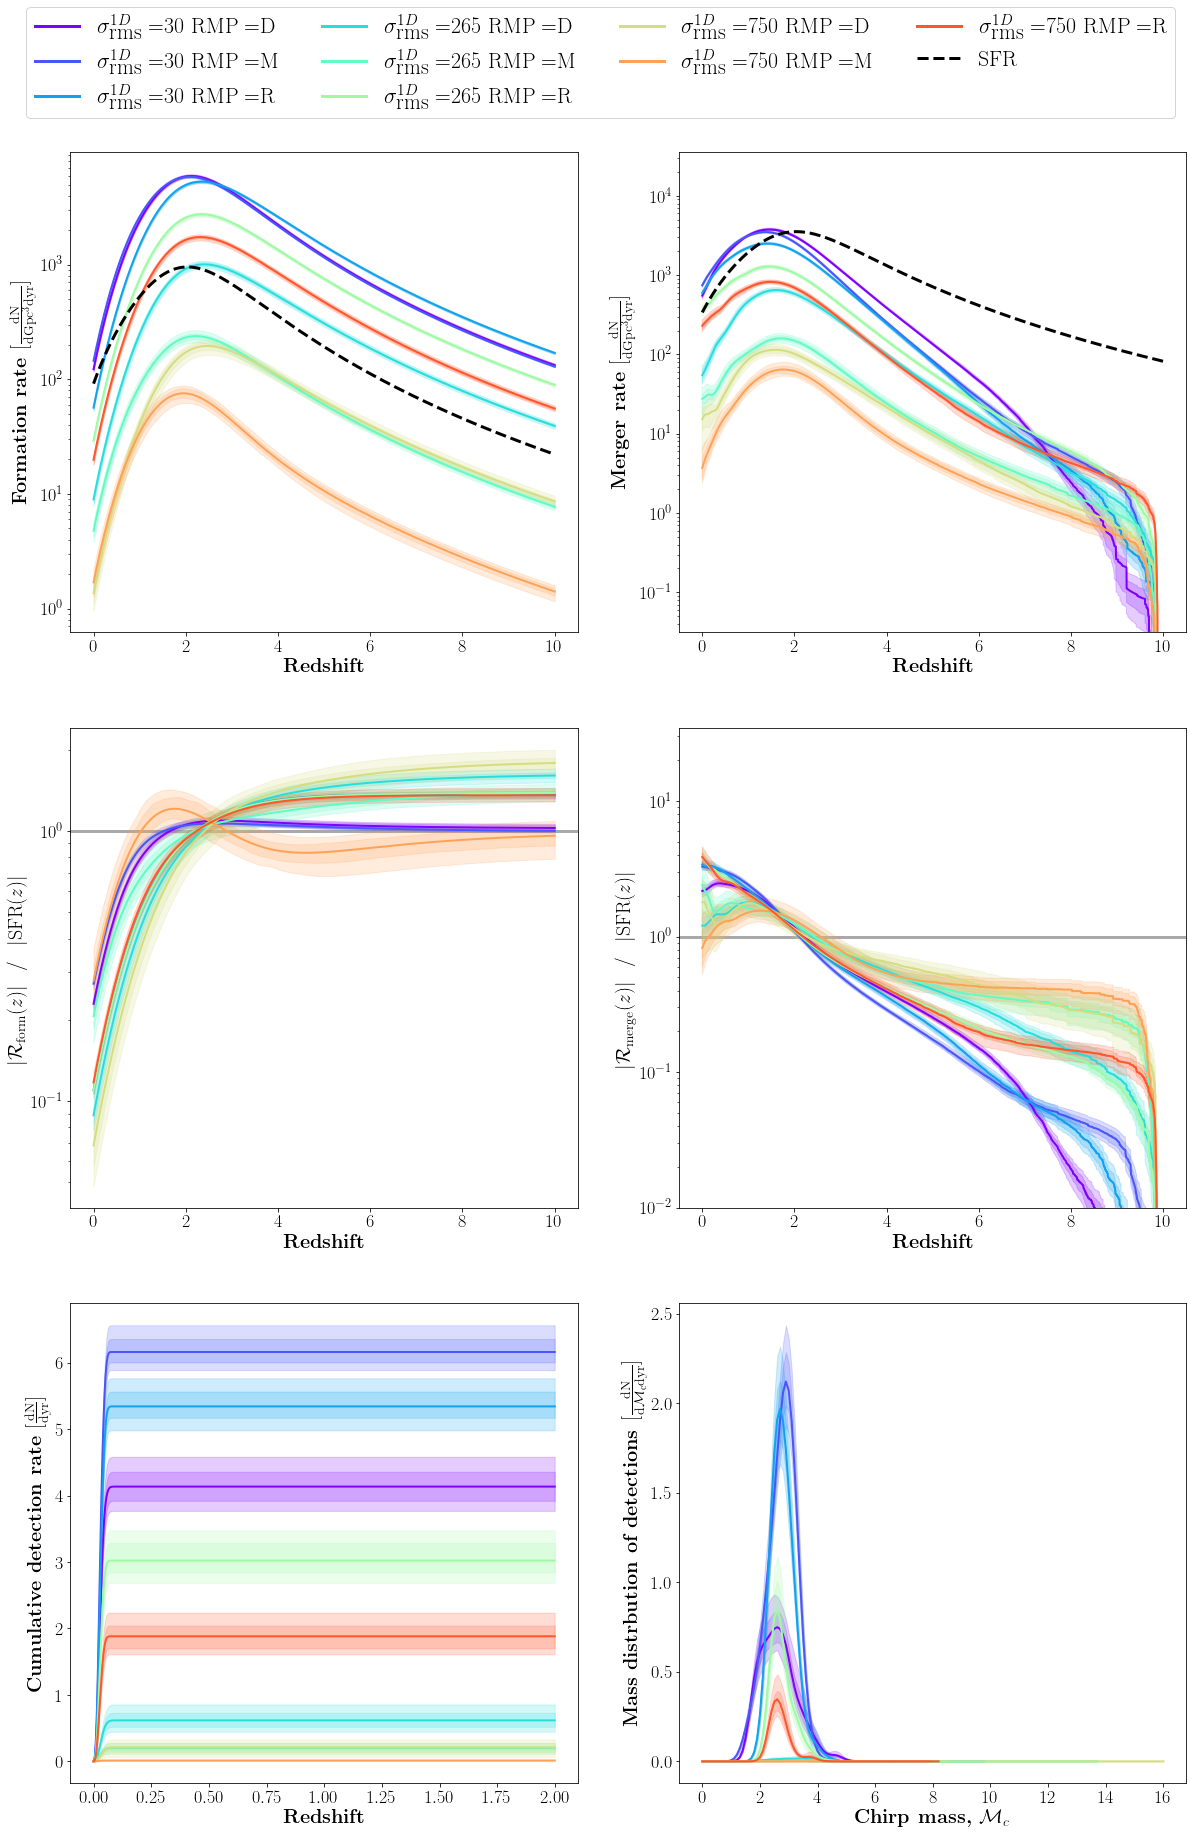

In [ ]:
plot_pickled_rates_sfr_norm(condensed_paths, velocity_dispersions, remnant_mass_ps, dco_type='BHNS', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100)                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS

## c) BBH

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


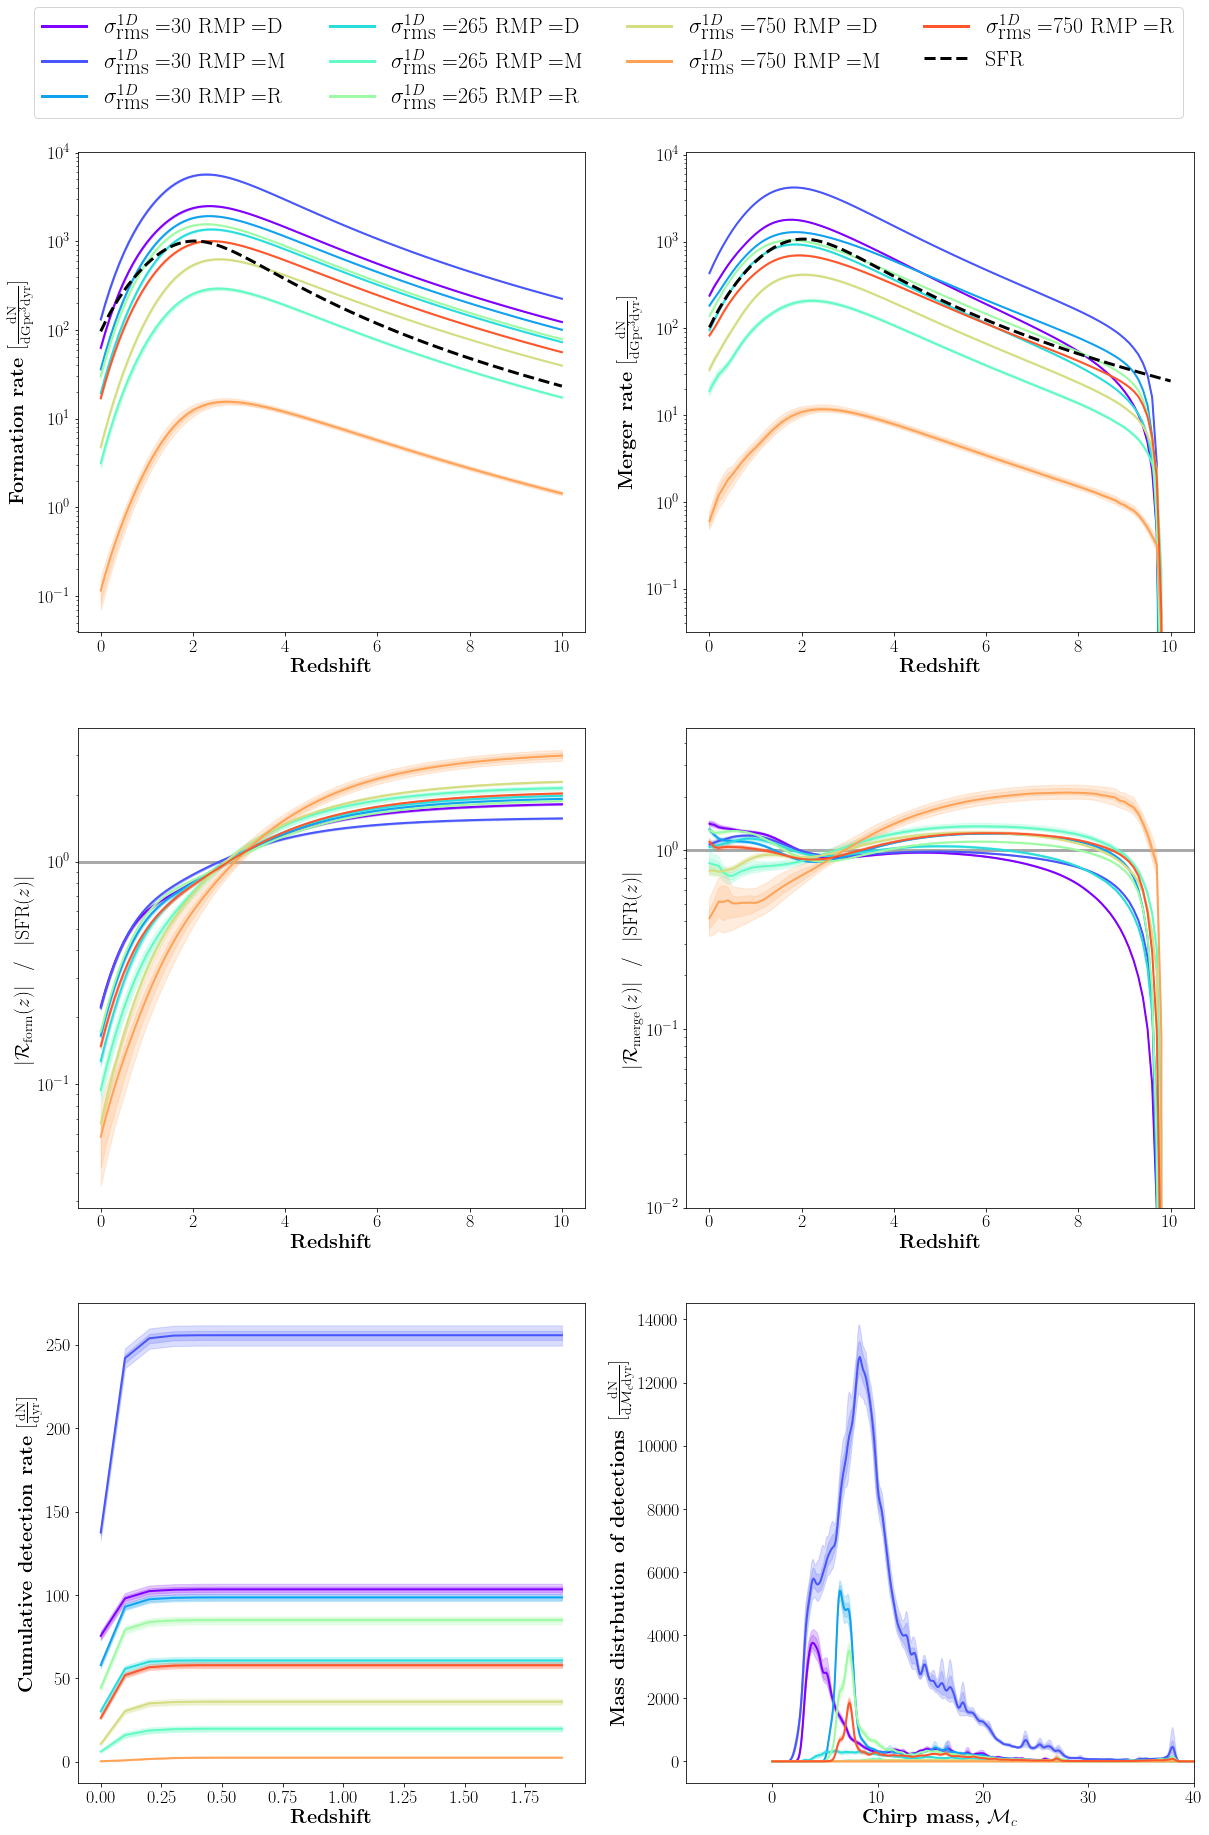

In [ ]:
plot_pickled_rates_sfr_norm(condensed_paths, velocity_dispersions, remnant_mass_ps, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100)                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS

# Double broken power law best fit parameters plots

Function to make and fit a double broken powerlaw

In [ ]:
def dbl_brkn_pow_law(redshifts, kappa0, kappa1, kappa2, break_index, max_index, R0):
    
    # Data broken up
    broken_redshifts = [redshifts[:break_index], redshifts[break_index:max_index], redshifts[max_index:]]

    # Calculate the rate
    rate0 = R0 * (1+broken_redshifts[0]) ** kappa0
    rate1 = (1+broken_redshifts[1]) ** kappa1
    rate2 = (1+broken_redshifts[2]) ** kappa2
    # rate = np.concatenate((rate, R0 * (1+broken_redshifts[0][-1])**(kappa0-kappa1) * (1+broken_redshifts[1]) ** kappa1))
    # rate = np.concatenate((rate, R0 * (1+broken_redshifts[0][-1])**(kappa0-kappa1) * (1+broken_redshifts[1][-1])**(kappa1-kappa2) * (1+broken_redshifts[2]) ** kappa2))
    rate = np.concatenate((rate0, rate1 * np.abs(rate0[-1] / rate1[0])))
    rate = np.concatenate((rate, rate2 * np.abs(rate[-1] / rate2[0])))

    return rate


def dbl_get_kappa_and_peak(redshifts, rate):

    # Get the index of the maximum rate
    max_index = np.argmax(rate)

    # Get the peak redshift
    peak_z = redshifts[max_index]

    # Get intrinsic rate
    R0 = rate[0]

    # Index of the first break
    break_index=int(max_index / 2)
    
    # Fit the data
    kappas, params_cov = curve_fit(lambda zs, kappa0, kappa1, kappa2: dbl_brkn_pow_law(zs, kappa0, kappa1, kappa2, break_index, max_index, R0), redshifts, rate)


    return kappas, peak_z

Function to plot the double broken power law best fit parameters

In [ ]:
def plot_rates_kappa_and_peaks(alpha_vals, beta_vals, color_grid, dco_type=None, lw=3, fs=24):
        
        assert dco_type != None, 'dco_type must be given'

        # Dictionaries to retrieve the data:
        total_formation_rates = {}
        total_merger_rates = {}
        one_sigma = {}
        two_sigma = {}
        formation_rate_kappa0 = {}
        formation_rate_kappa1 = {}
        formation_rate_kappa2 = {}
        merger_rate_kappa0 = {}
        merger_rate_kappa1 = {}
        merger_rate_kappa2 = {}
        formation_rate_peak_zs = {}
        merger_rate_peak_zs = {}
        redshifts = {}
        intrinsic_formation_rate = {}
        intrinsic_merger_rate = {}

        ######################################################################
        # Retrieve the data
        index = 0
        for alpha_val in alpha_vals:
                # Make the dictionary "2D"
                total_formation_rates[alpha_val] = {}
                total_merger_rates[alpha_val] = {}
                one_sigma[alpha_val] = {}
                two_sigma[alpha_val] = {}
                formation_rate_kappa0[alpha_val] = {}
                formation_rate_kappa1[alpha_val] = {}
                formation_rate_kappa2[alpha_val] = {}
                merger_rate_kappa0[alpha_val] = {}
                merger_rate_kappa1[alpha_val] = {}
                merger_rate_kappa2[alpha_val] = {}
                formation_rate_peak_zs[alpha_val] = {}
                merger_rate_peak_zs[alpha_val] = {}
                redshifts[alpha_val] = {}         
                intrinsic_formation_rate[alpha_val] = {}
                intrinsic_merger_rate[alpha_val] = {}

                for beta_val in beta_vals:
                        one_sigma[alpha_val][beta_val] = {}
                        two_sigma[alpha_val][beta_val] = {}
                        with open('/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_sigma_remnant_prescription/output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                                
                                # Get data
                                h5_data = h5.File(f)
                                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]

                                # GET RATE KAPPAS, Z_PEAK, AND R0                                
                                # Get the intrinsic rates
                                intrinsic_formation_rate[alpha_val][beta_val] = total_formation_rates[alpha_val][beta_val][0]
                                intrinsic_merger_rate[alpha_val][beta_val] = total_merger_rates[alpha_val][beta_val][0]

                                # Get kappas
                                # Formation rates
                                formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_formation_rates[alpha_val][beta_val]/max(total_formation_rates[alpha_val][beta_val]))
                                formation_rate_peak_zs[alpha_val][beta_val] = formation_rate_peak_z
                                formation_rate_kappa0[alpha_val][beta_val] = formation_rate_kappas[0]
                                formation_rate_kappa1[alpha_val][beta_val] = formation_rate_kappas[1]
                                formation_rate_kappa2[alpha_val][beta_val] = formation_rate_kappas[2]
                                # Merger rates
                                merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_merger_rates[alpha_val][beta_val]/max(total_merger_rates[alpha_val][beta_val]))
                                merger_rate_peak_zs[alpha_val][beta_val] = merger_rate_peak_z
                                merger_rate_kappa0[alpha_val][beta_val] = merger_rate_kappas[0]
                                merger_rate_kappa1[alpha_val][beta_val] = merger_rate_kappas[1]
                                merger_rate_kappa2[alpha_val][beta_val] = merger_rate_kappas[2]


                                # CONFIDENCE INTERVALS!
                                # Iterate through all the bootstrapped rates and calculate the kappa values for the rates
                                formation_rate_kappa0s = []
                                formation_rate_kappa1s = []
                                formation_rate_kappa2s = []
                                formation_rate_peaks = []
                                merger_rate_kappa0s = []
                                merger_rate_kappa1s = []
                                merger_rate_kappa2s = []
                                merger_rate_peaks = []
                                intrinsic_formation_rates = []
                                intrinsic_merger_rates = []
                                for rate_index in range(len(h5_data['Bootstraps']['total_formation_rates'][...])):
                                        
                                        # Get the akppa for the current bootstrap iteration
                                        if np.argmax(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]) != 0 and np.argmax(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
                                                # Get the kappas and peaks
                                                formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_formation_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]))
                                                merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_merger_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]))

                                                # Store the kappas
                                                formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
                                                formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
                                                formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
                                                merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
                                                merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
                                                merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

                                                # Store the peaks
                                                formation_rate_peaks.append(formation_rate_peak)
                                                merger_rate_peaks.append(merger_rate_peak)

                                                # Get the intrinsic rates
                                                intrinsic_formation_rates.append(h5_data['Bootstraps']['total_formation_rates'][...][rate_index][0])
                                                intrinsic_merger_rates.append(h5_data['Bootstraps']['total_merger_rates'][...][rate_index][0])


                                # Get and store the confidence intervals for the kappas
                                # Formation rates
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
                                # Merger rates
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])


                                        
        # ######################################################################
        # # Plot the formation rate kappas and z_peak
        # formation_fig, formation_axes = plt.subplots(1, 5, figsize=(24, 13))

        # # Make grid in background
        # formation_axes[0].grid(alpha=0.5, zorder=-1)
        # formation_axes[1].grid(alpha=0.5, zorder=-1)
        # formation_axes[2].grid(alpha=0.5, zorder=-1)
        # formation_axes[3].grid(alpha=0.5, zorder=-1)
        # formation_axes[4].grid(alpha=0.5, zorder=-1)

        # Retreive the SFR
        MSSFR = ClassMSSFR.MSSFR()                                                      # Create an MSSFR object
        MSSFR.SFRprescription = SFRprescription                                         # Set SFR prescription
        ages = MSSFR.cosmology.age(redshifts[alpha_val][beta_val]).value                # Get the ages
        sfr = MSSFR.returnSFR(redshifts[alpha_val][beta_val], ages)                     # Get the SFR

        sfr_kappas, sfr_peak_redshift = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], sfr/max(sfr))
        intrinsic_sfr = sfr[0]
        sfr_kappa0 = sfr_kappas[0]
        sfr_kappa1 = sfr_kappas[1]
        sfr_kappa2 = sfr_kappas[2]


        index = 0
        dy = 0.8
        dylen = (2*dy)/(len(alpha_vals)*len(beta_vals))
        labels = []
        label_indexs = []
        # for alpha_val in alpha_vals:
        #         for beta_val in beta_vals:

        #                 # Plot the intrinsic rate
        #                 formation_axes[0].scatter(x=intrinsic_formation_rate[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                          # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0]                                                           # Get the width of the 1sigma error bar
        #                 formation_axes[0].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)       # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][1] - two_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0]                                                           # Get the width of the 2sigma error bar
        #                 formation_axes[0].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['intrinsic_formation_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)       # 2sigma error bar

        #                 # Plot Kappa0
        #                 formation_axes[1].scatter(x=formation_rate_kappa0[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                             # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_kappa0'][1] - one_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[1].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_kappa0'][1] - two_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[1].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Plot Kappa1
        #                 formation_axes[2].scatter(x=formation_rate_kappa1[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                             # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_kappa1'][1] - one_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[2].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_kappa1'][1] - two_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[2].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Plot z_max
        #                 formation_axes[3].scatter(x=formation_rate_peak_zs[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                            # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_peak_z'][1] - one_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[3].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_peak_z'][1] - two_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[3].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Plot Kappa2
        #                 formation_axes[4].scatter(x=formation_rate_kappa2[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                             # Point at estimated value
        #                 width = one_sigma[alpha_val][beta_val]['formation_rate_kappa2'][1] - one_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0]                                                                 # Get the width of the 1sigma error bar
        #                 formation_axes[4].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 1sigma error bar
        #                 width = two_sigma[alpha_val][beta_val]['formation_rate_kappa2'][1] - two_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0]                                                                 # Get the width of the 2sigma error bar
        #                 formation_axes[4].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['formation_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)          # 2sigma error bar

        #                 # Add model values to the labels list
        #                 labels.append(r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
        #                 label_indexs.append(index)

        #                 index+=1

        # # Plot SFR values
        # formation_axes[1].axvline(x=sfr_kappa0, linestyle='--', color='black', lw=lw, zorder=10)                # Plot kappa0 for the sfr
        # formation_axes[2].axvline(x=sfr_kappa1, linestyle='--', color='black', lw=lw, zorder=10)                # Plot kappa1 for the sfr
        # formation_axes[3].axvline(x=sfr_peak_redshift, linestyle='--', color='black', lw=lw, zorder=10)         # Plot z_peak for the sfr
        # formation_axes[4].axvline(x=sfr_kappa2, linestyle='--', color='black', lw=lw, zorder=10)                # Plot kappa2 for the sfr

        # # Label axes of all the plots
        # formation_axes[0].set_xlabel(r'$R_0$', fontsize=fs)
        # formation_axes[1].set_xlabel(r'$\kappa_0$', fontsize=fs)
        # formation_axes[0].set_ylabel(r'\textbf{Model}', fontsize=fs)
        # formation_axes[2].set_xlabel(r'$\kappa_1$', fontsize=fs)
        # formation_axes[3].set_xlabel(r'$z_\textrm{peak}$', fontsize=fs)
        # formation_axes[4].set_xlabel(r'$\kappa_2$', fontsize=fs)

        # for ax_index, ax in enumerate(formation_axes.flatten()):
        #         ax.tick_params(labelsize=0.9*fs)
        #         ax.set_yticks(label_indexs)
        #         if ax_index == 0:       
        #                 ax.set_yticklabels(labels)
        #         else:
        #                 ax.set_yticklabels(['' for i in range(len(labels))])

        # # Save and show the plot!
        # # plt.savefig('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data_Analysis/Figures/Rates_Kappas_and_Peaks/'+ dco_type + '_Formation_Kappas_and_Peak.png')
        # plt.show()



        ######################################################################
        # Plot the merger rate kappas and z_peak
        merger_fig, merger_axes = plt.subplots(1, 5, figsize=(24, 13))

        # Make grid in background
        merger_axes[0].grid(alpha=0.5, zorder=-1)
        merger_axes[1].grid(alpha=0.5, zorder=-1)
        merger_axes[2].grid(alpha=0.5, zorder=-1)
        merger_axes[3].grid(alpha=0.5, zorder=-1)
        merger_axes[4].grid(alpha=0.5, zorder=-1)

        index = 0
        labels = []
        label_indexs = []
        for alpha_val in alpha_vals:
                for beta_val in beta_vals:

                        # Plot the intrinsic rate
                        merger_axes[0].scatter(x=intrinsic_merger_rate[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 1sigma error bar
                        merger_axes[0].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)             # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                 # Get the width of the 2sigma error bar
                        merger_axes[0].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)             # 2sigma error bar

                        # Plot Kappa0
                        merger_axes[1].scatter(x=merger_rate_kappa0[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                   # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_kappa0'][1] - one_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[1].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_kappa0'][1] - two_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[1].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_kappa0'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Plot Kappa1
                        merger_axes[2].scatter(x=merger_rate_kappa1[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                   # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_kappa1'][1] - one_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[2].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_kappa1'][1] - two_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[2].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_kappa1'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Plot z_max
                        merger_axes[3].scatter(x=merger_rate_peak_zs[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                  # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_peak_z'][1] - one_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[3].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_peak_z'][1] - two_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[3].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_peak_z'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Plot Kappa2
                        merger_axes[4].scatter(x=merger_rate_kappa2[alpha_val][beta_val], y=index, s=100, color=color_grid[alpha_val][beta_val], alpha=1, zorder=100)                                                   # Point at estimated value
                        width = one_sigma[alpha_val][beta_val]['merger_rate_kappa2'][1] - one_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0]                                                                       # Get the width of the 1sigma error bar
                        merger_axes[4].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 1sigma error bar
                        width = two_sigma[alpha_val][beta_val]['merger_rate_kappa2'][1] - two_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0]                                                                       # Get the width of the 2sigma error bar
                        merger_axes[4].barh(index, width=width, left=two_sigma[alpha_val][beta_val]['merger_rate_kappa2'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)                # 2sigma error bar

                        # Add model values to the labels list
                        labels.append(r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val + r'$\textrm{ RMP} = $' + beta_val)
                        label_indexs.append(index)

                        index+=1
        
        
        # Plot SFR values
        merger_axes[1].axvline(x=sfr_kappa0, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr
        merger_axes[2].axvline(x=sfr_kappa1, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa1 for the sfr
        merger_axes[3].axvline(x=sfr_peak_redshift, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                    # Plot kappa0 for the sfr
        merger_axes[4].axvline(x=sfr_kappa2, linestyle='--', color='black', lw=lw, zorder=10)                                                                                                           # Plot kappa0 for the sfr

        # Add 90% confidence interval from 03 Ligo/Virgo 2022; The population of merging compact...
        if dco_type == 'BNS':
                merger_axes[0].axvspan(10, 1700, alpha=0.3, color='gray', zorder=-1)
        elif dco_type == 'BHNS':
                merger_axes[0].axvspan(7.8, 140, alpha=0.3, color='gray', zorder=-1)
        elif dco_type == 'BBH':
                merger_axes[0].axvspan(16, 61, alpha=0.3, color='gray', zorder=-1)

        
        # Label axes of all the plots
        merger_axes[0].set_xlabel(r'$R_0$', fontsize=fs)
        merger_axes[1].set_xlabel(r'$\kappa_0$', fontsize=fs)
        merger_axes[0].set_ylabel(r'\textbf{Model}', fontsize=fs)
        merger_axes[2].set_xlabel(r'$\kappa_1$', fontsize=fs)
        merger_axes[3].set_xlabel(r'$z_\textrm{peak}$', fontsize=fs)
        merger_axes[4].set_xlabel(r'$\kappa_2$', fontsize=fs)

        for ax_index, ax in enumerate(merger_axes.flatten()):
                ax.tick_params(labelsize=0.9*fs)
                ax.set_yticks(label_indexs)
                if ax_index == 0:       
                        ax.set_yticklabels(labels)
                else:
                        ax.set_yticklabels(['' for i in range(len(labels))])
        
        # Save and show the plot!
        # plt.savefig('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data_Analysis/Figures/Rates_Kappas_and_Peaks/'+ dco_type + '_Merger_Kappas_and_Peak.png')
        plt.show()

## a) BNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


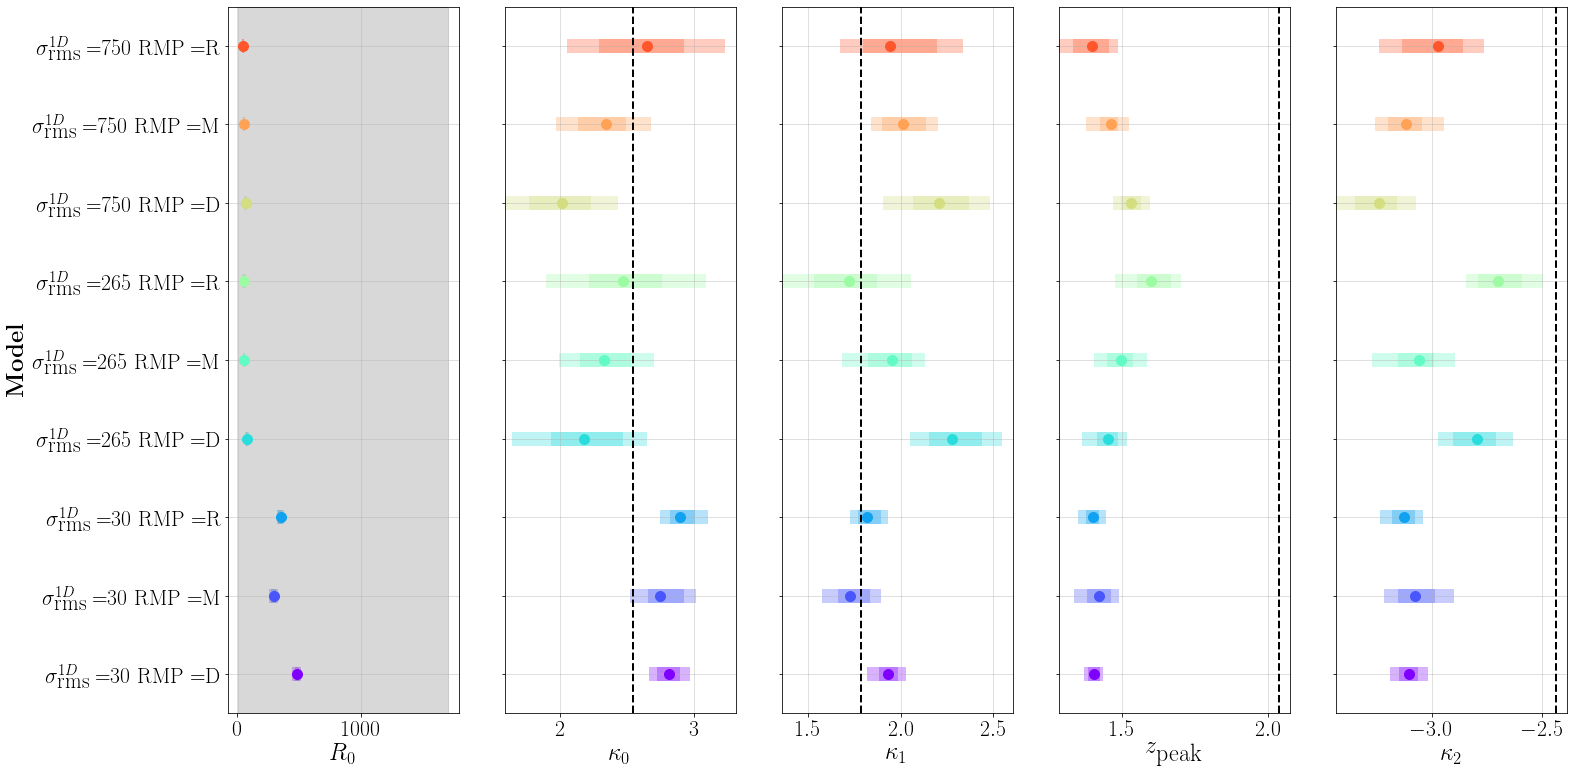

In [ ]:
plot_rates_kappa_and_peaks(velocity_dispersions, remnant_mass_ps, color_grid=color_grid, dco_type='BNS', lw=2)

## b) BHNS

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


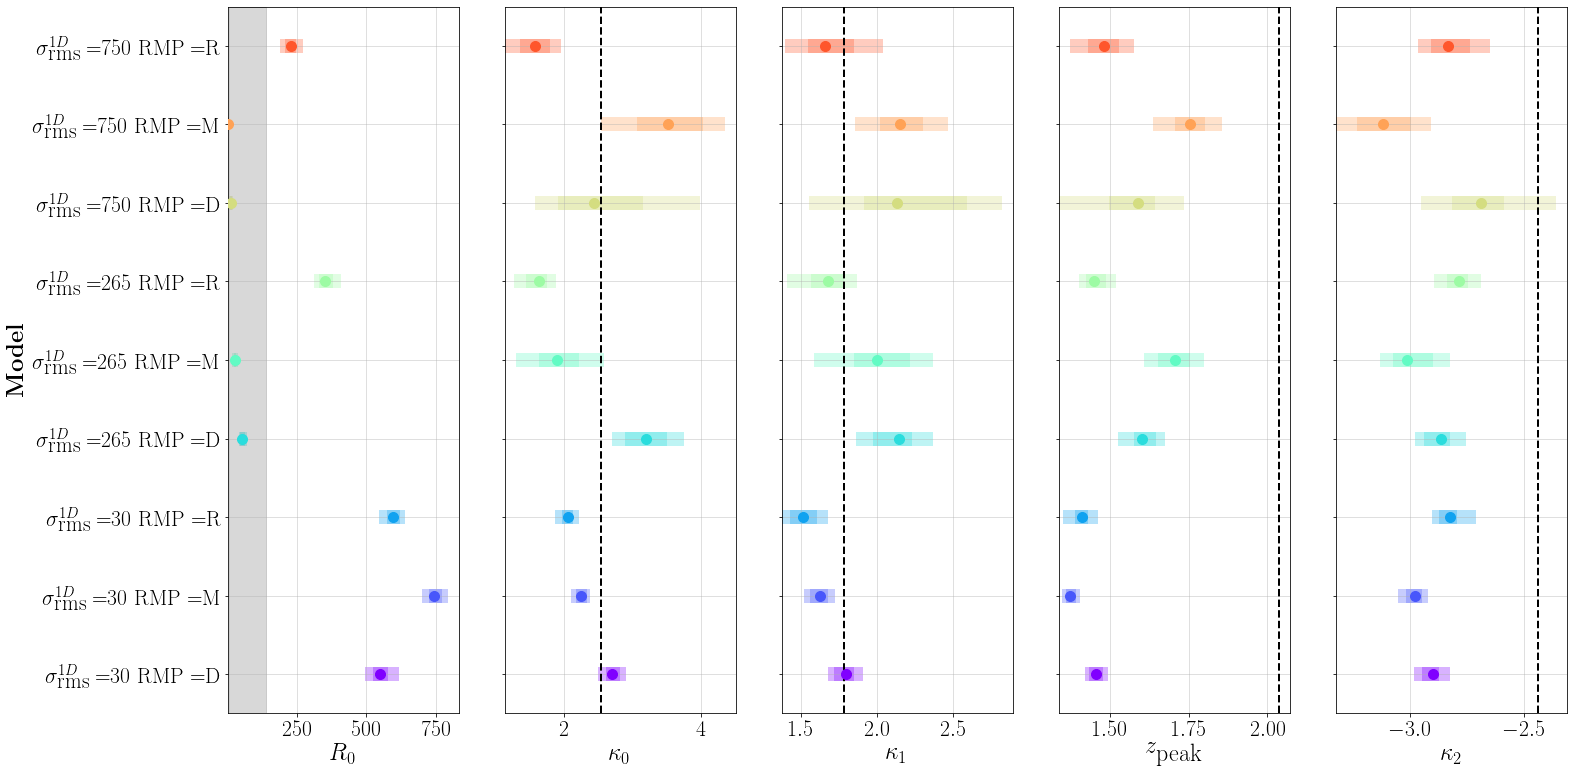

In [ ]:
plot_rates_kappa_and_peaks(velocity_dispersions, remnant_mass_ps, color_grid=color_grid, dco_type='BHNS', lw=2)

## c) BBH

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


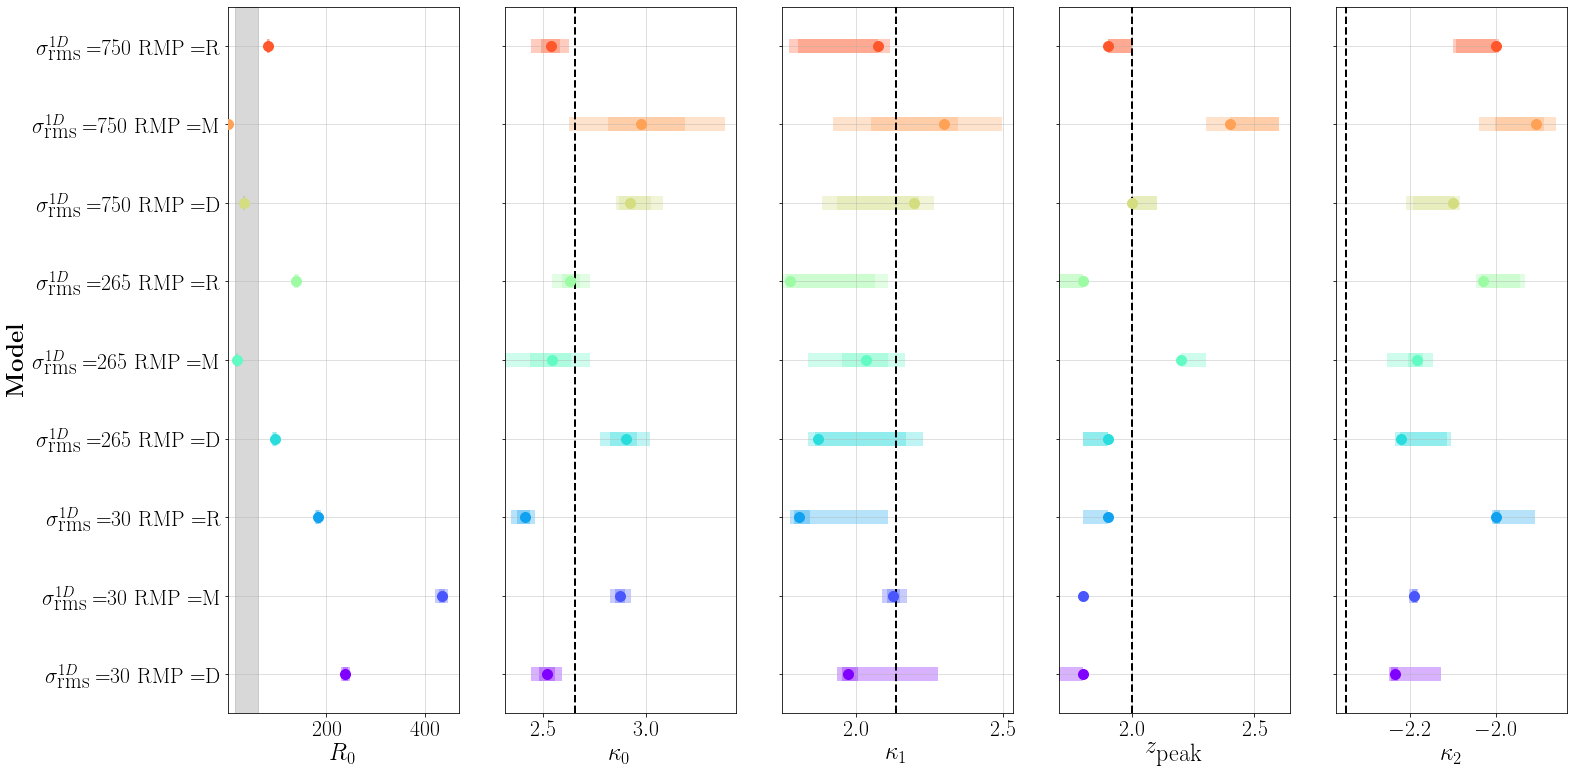

In [ ]:
plot_rates_kappa_and_peaks(velocity_dispersions, remnant_mass_ps, color_grid=color_grid, dco_type='BBH', lw=2)

# Plot double broken power law fit as function of uncertainty values

The color grids

In [ ]:
rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
num_colors = len(velocity_dispersions) + len(remnant_mass_ps)

alpha_color_grid = []
counter=0
for alpha_index, alpha in enumerate(velocity_dispersions):
    alpha_color_grid.append(rainbow_cmap(counter/num_colors))
    counter+=1

beta_color_grid = []
for beta_index, beta in enumerate(remnant_mass_ps):
    beta_color_grid.append(rainbow_cmap(counter/num_colors))
    counter+=1

The function to plot

In [ ]:
def plot_functions_of_params(alpha_vals, beta_vals, alpha_color_grid, beta_color_grid, dco_type=None, lw=3, fs=24, markersize=4):
        
        assert dco_type != None, 'dco_type must be given'

        # Dictionaries to retrieve the data:
        total_formation_rates = {}
        total_merger_rates = {}
        one_sigma = {}
        two_sigma = {}
        formation_rate_kappa0 = {}
        formation_rate_kappa1 = {}
        formation_rate_kappa2 = {}
        merger_rate_kappa0 = {}
        merger_rate_kappa1 = {}
        merger_rate_kappa2 = {}
        formation_rate_peak_zs = {}
        merger_rate_peak_zs = {}
        redshifts = {}
        intrinsic_formation_rate = {}
        intrinsic_merger_rate = {}

        ######################################################################
        # Retrieve the data
        index = 0
        for alpha_val in alpha_vals:
                # Make the dictionary "2D"
                total_formation_rates[alpha_val] = {}
                total_merger_rates[alpha_val] = {}
                one_sigma[alpha_val] = {}
                two_sigma[alpha_val] = {}
                formation_rate_kappa0[alpha_val] = {}
                formation_rate_kappa1[alpha_val] = {}
                formation_rate_kappa2[alpha_val] = {}
                merger_rate_kappa0[alpha_val] = {}
                merger_rate_kappa1[alpha_val] = {}
                merger_rate_kappa2[alpha_val] = {}
                formation_rate_peak_zs[alpha_val] = {}
                merger_rate_peak_zs[alpha_val] = {}
                redshifts[alpha_val] = {}         
                intrinsic_formation_rate[alpha_val] = {}
                intrinsic_merger_rate[alpha_val] = {}

                for beta_val in beta_vals:
                        one_sigma[alpha_val][beta_val] = {}
                        two_sigma[alpha_val][beta_val] = {}
                        
                        with open('/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_sigma_remnant_prescription/output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                                
                                # Get data
                                h5_data = h5.File(f)
                                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]

                                # GET RATE KAPPAS, Z_PEAK, AND R0                                
                                # Get the intrinsic rates
                                intrinsic_formation_rate[alpha_val][beta_val] = total_formation_rates[alpha_val][beta_val][0]
                                intrinsic_merger_rate[alpha_val][beta_val] = total_merger_rates[alpha_val][beta_val][0]

                                # Get kappas
                                # Formation rates
                                formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_formation_rates[alpha_val][beta_val]/max(total_formation_rates[alpha_val][beta_val]))
                                formation_rate_peak_zs[alpha_val][beta_val] = formation_rate_peak_z
                                formation_rate_kappa0[alpha_val][beta_val] = formation_rate_kappas[0]
                                formation_rate_kappa1[alpha_val][beta_val] = formation_rate_kappas[1]
                                formation_rate_kappa2[alpha_val][beta_val] = formation_rate_kappas[2]
                                # Merger rates
                                merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_merger_rates[alpha_val][beta_val]/max(total_merger_rates[alpha_val][beta_val]))
                                merger_rate_peak_zs[alpha_val][beta_val] = merger_rate_peak_z
                                merger_rate_kappa0[alpha_val][beta_val] = merger_rate_kappas[0]
                                merger_rate_kappa1[alpha_val][beta_val] = merger_rate_kappas[1]
                                merger_rate_kappa2[alpha_val][beta_val] = merger_rate_kappas[2]


                                # CONFIDENCE INTERVALS!
                                # Iterate through all the bootstrapped rates and calculate the kappa values for the rates
                                formation_rate_kappa0s = []
                                formation_rate_kappa1s = []
                                formation_rate_kappa2s = []
                                formation_rate_peaks = []
                                merger_rate_kappa0s = []
                                merger_rate_kappa1s = []
                                merger_rate_kappa2s = []
                                merger_rate_peaks = []
                                intrinsic_formation_rates = []
                                intrinsic_merger_rates = []
                                for rate_index in range(len(h5_data['Bootstraps']['total_formation_rates'][...])):
                                        
                                        # Get the akppa for the current bootstrap iteration
                                        if np.argmax(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]) != 0 and np.argmax(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
                                                # Get the kappas and peaks
                                                formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_formation_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_formation_rates'][...][rate_index]))
                                                merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], h5_data['Bootstraps']['total_merger_rates'][...][rate_index]/max(h5_data['Bootstraps']['total_merger_rates'][...][rate_index]))

                                                # Store the kappas
                                                formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
                                                formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
                                                formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
                                                merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
                                                merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
                                                merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

                                                # Store the peaks
                                                formation_rate_peaks.append(formation_rate_peak)
                                                merger_rate_peaks.append(merger_rate_peak)

                                                # Get the intrinsic rates
                                                intrinsic_formation_rates.append(h5_data['Bootstraps']['total_formation_rates'][...][rate_index][0])
                                                intrinsic_merger_rates.append(h5_data['Bootstraps']['total_merger_rates'][...][rate_index][0])


                                # Get and store the confidence intervals for the kappas
                                # Formation rates
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
                                # Merger rates
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
                                one_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
                                one_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
                                two_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])
                        # with open('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/Pickled_Rates/MSSSFR_111/' + dco_type + '/alpha_CE_' + alpha_val + '_beta_' + beta_val + '.pkl', 'rb') as f:
                                
                        #         # GET RATE KAPPAS, Z_PEAK, AND R0
                        #         # Get peaks
                        #         dict = pickle.load(f)
                        #         total_formation_rates[alpha_val][beta_val] = dict['total_formation_rates']
                        #         total_merger_rates[alpha_val][beta_val] = dict['total_merger_rates']
                        #         # redshifts[alpha_val][beta_val] = dict['redshfits']
                        #         redshifts[alpha_val][beta_val] = np.linspace(0, 10, num=len(dict['total_merger_rates']))

                        #         # Get the intrinsic rates
                        #         intrinsic_formation_rate[alpha_val][beta_val] = total_formation_rates[alpha_val][beta_val][0]
                        #         intrinsic_merger_rate[alpha_val][beta_val] = total_merger_rates[alpha_val][beta_val][0]

                        #         # Get kappas
                        #         # Formation rates
                        #         formation_rate_kappas, formation_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_formation_rates[alpha_val][beta_val]/max(total_formation_rates[alpha_val][beta_val]))
                        #         formation_rate_peak_zs[alpha_val][beta_val] = formation_rate_peak_z
                        #         formation_rate_kappa0[alpha_val][beta_val] = formation_rate_kappas[0]
                        #         formation_rate_kappa1[alpha_val][beta_val] = formation_rate_kappas[1]
                        #         formation_rate_kappa2[alpha_val][beta_val] = formation_rate_kappas[2]
                        #         # Merger rates
                        #         merger_rate_kappas, merger_rate_peak_z = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val],  total_merger_rates[alpha_val][beta_val]/max(total_merger_rates[alpha_val][beta_val]))
                        #         merger_rate_peak_zs[alpha_val][beta_val] = merger_rate_peak_z
                        #         merger_rate_kappa0[alpha_val][beta_val] = merger_rate_kappas[0]
                        #         merger_rate_kappa1[alpha_val][beta_val] = merger_rate_kappas[1]
                        #         merger_rate_kappa2[alpha_val][beta_val] = merger_rate_kappas[2]


                        #         # CONFIDENCE INTERVALS!
                        #         # Iterate through all the bootstrapped rates and calculate the kappa values for the rates
                        #         formation_rate_kappa0s = []
                        #         formation_rate_kappa1s = []
                        #         formation_rate_kappa2s = []
                        #         formation_rate_peaks = []
                        #         merger_rate_kappa0s = []
                        #         merger_rate_kappa1s = []
                        #         merger_rate_kappa2s = []
                        #         merger_rate_peaks = []
                        #         intrinsic_formation_rates = []
                        #         intrinsic_merger_rates = []
                        #         for rate_index in range(len(dict['bootstraps']['total_formation_rates'])):
                                        
                        #                 # Get the akppa for the current bootstrap iteration
                        #                 if np.argmax(dict['bootstraps']['total_formation_rates'][rate_index]) != 0 and np.argmax(dict['bootstraps']['total_merger_rates'][rate_index]) != 0: # We will not count the bootstrapped rate if the rate's max is at z=0
                        #                         # Get the kappas and peaks
                        #                         formation_rate_kappas_bs, formation_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], dict['bootstraps']['total_formation_rates'][rate_index]/max(dict['bootstraps']['total_formation_rates'][rate_index]))
                        #                         merger_rate_kappas_bs, merger_rate_peak = dbl_get_kappa_and_peak(redshifts[alpha_val][beta_val], dict['bootstraps']['total_merger_rates'][rate_index]/max(dict['bootstraps']['total_merger_rates'][rate_index]))

                        #                         # Store the kappas
                        #                         formation_rate_kappa0s.append(formation_rate_kappas_bs[0])
                        #                         formation_rate_kappa1s.append(formation_rate_kappas_bs[1])
                        #                         formation_rate_kappa2s.append(formation_rate_kappas_bs[2])
                        #                         merger_rate_kappa0s.append(merger_rate_kappas_bs[0])
                        #                         merger_rate_kappa1s.append(merger_rate_kappas_bs[1])
                        #                         merger_rate_kappa2s.append(merger_rate_kappas_bs[2])

                        #                         # Store the peaks
                        #                         formation_rate_peaks.append(formation_rate_peak)
                        #                         merger_rate_peaks.append(merger_rate_peak)

                        #                         # Get the intrinsic rates
                        #                         intrinsic_formation_rates.append(dict['bootstraps']['total_formation_rates'][rate_index][0])
                        #                         intrinsic_merger_rates.append(dict['bootstraps']['total_merger_rates'][rate_index][0])


                        #         # Get and store the confidence intervals for the kappas
                        #         # Formation rates
                        #         one_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [16, 84])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_kappa0']         = np.percentile(formation_rate_kappa0s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_kappa1']         = np.percentile(formation_rate_kappa1s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_kappa2']         = np.percentile(formation_rate_kappa2s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['formation_rate_peak_z']         = np.percentile(formation_rate_peaks, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['intrinsic_formation_rate']      = np.percentile(intrinsic_formation_rates, [2.5, 97.5])
                        #         # Merger rates
                        #         one_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [16, 84])
                        #         one_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [16, 84])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_kappa0']            = np.percentile(merger_rate_kappa0s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_kappa1']            = np.percentile(merger_rate_kappa1s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_kappa2']            = np.percentile(merger_rate_kappa2s, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['merger_rate_peak_z']            = np.percentile(merger_rate_peaks, [2.5, 97.5])
                        #         two_sigma[alpha_val][beta_val]['intrinsic_merger_rate']         = np.percentile(intrinsic_merger_rates, [2.5, 97.5])


        ######################################################################
        # Plot the merger rate kappas and z_peak
        merger_fig, merger_axes = plt.subplots(5, 2, figsize=(24, 24))

        # Make grid in background
        for ax_index, ax in enumerate(merger_axes[:, 0].flatten()):
                ax.set_xscale('log')
        #         ax.set_yscale('log')
        # merger_axes[0].grid(alpha=0.5, zorder=-1)
        # merger_axes[1].grid(alpha=0.5, zorder=-1)
        # merger_axes[2].grid(alpha=0.5, zorder=-1)
        # merger_axes[3].grid(alpha=0.5, zorder=-1)
        # merger_axes[4].grid(alpha=0.5, zorder=-1)

        index = 0
        labels = []
        label_indexs = []
        alpha_floats = np.array(alpha_vals).astype(float)
        for beta_index, beta_val in enumerate(beta_vals): 
                R0s = []
                kappa0s = []
                kappa1s = []
                kappa2s = []
                z_peaks = []
                for alpha_val in alpha_vals:
                        R0s.append(intrinsic_merger_rate[alpha_val][beta_val])
                        kappa0s.append(merger_rate_kappa0[alpha_val][beta_val])
                        kappa1s.append(merger_rate_kappa1[alpha_val][beta_val])
                        kappa2s.append(merger_rate_kappa2[alpha_val][beta_val])
                        z_peaks.append(merger_rate_peak_zs[alpha_val][beta_val])
                
                # Plot the values
                merger_axes[0, 0].plot(alpha_floats, R0s, color=beta_color_grid[beta_index], lw=3, zorder=-1, label=r'RMP = ' + beta_val)
                merger_axes[0, 0].scatter(alpha_floats, R0s, color='black', s=markersize)

                merger_axes[1, 0].plot(alpha_floats, kappa0s, color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[1, 0].scatter(alpha_floats, kappa0s, color='black', s=markersize)

                merger_axes[2, 0].plot(alpha_floats, kappa1s, color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[2, 0].scatter(alpha_floats, kappa1s, color='black', s=markersize)

                merger_axes[3, 0].plot(alpha_floats, z_peaks, color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[3, 0].scatter(alpha_floats, z_peaks, color='black', s=markersize)

                merger_axes[4, 0].plot(alpha_floats, np.absolute(kappa2s), color=beta_color_grid[beta_index], lw=3, zorder=-1)
                merger_axes[4, 0].scatter(alpha_floats, np.absolute(kappa2s), color='black', s=markersize)


        # for alpha_val in alpha_vals:
        #         for index, beta_val in enumerate(beta_vals):
        #                 height = one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                       # Get the width of the 1sigma error bar
        #                 merger_axes[0, 1].bar(float(beta_val), two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1], width=0.008, bottom=R0s - two_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], align='center', alpha=0.3)
        
        # beta_floats = np.array(beta_vals).astype(float)
        for alpha_index, alpha_val in enumerate(alpha_vals):
                # Get a numpy arrays of the values for each plot
                R0s = np.array(list(intrinsic_merger_rate[alpha_val].values()))
                kappa0s = np.array(list(merger_rate_kappa0[alpha_val].values()))
                kappa1s = np.array(list(merger_rate_kappa1[alpha_val].values()))
                kappa2s = np.array(list(merger_rate_kappa2[alpha_val].values()))
                z_peaks = np.array(list(merger_rate_peak_zs[alpha_val].values()))

                # Plot the values
                # merger_axes[0].barh(index, width=width, left=one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], color=color_grid[alpha_val][beta_val], alpha=0.3, height=dylen, zorder=-1)             # 1sigma error bar
                # for index, beta_val in enumerate(beta_vals):
                #         height = one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][1] - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0]                                                                       # Get the width of the 1sigma error bar
                #         merger_axes[0, 1].bar(float(beta_val), height, width=0.008, bottom=R0s - one_sigma[alpha_val][beta_val]['intrinsic_merger_rate'][0], align='center', log=True, alpha=0.3)



                merger_axes[0, 1].plot(beta_vals, R0s, color=alpha_color_grid[alpha_index], lw=3, zorder=-1, label=r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val)
                merger_axes[0, 1].scatter(beta_vals, R0s, color='black', s=markersize)

                merger_axes[1, 1].plot(beta_vals, kappa0s, color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[1, 1].scatter(beta_vals, kappa0s, color='black', s=markersize)

                merger_axes[2, 1].plot(beta_vals, kappa1s, color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[2, 1].scatter(beta_vals, kappa1s, color='black', s=markersize)

                merger_axes[3, 1].plot(beta_vals, z_peaks, color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[3, 1].scatter(beta_vals, z_peaks, color='black', s=markersize)

                merger_axes[4, 1].plot(beta_vals, np.absolute(kappa2s), color=alpha_color_grid[alpha_index], lw=3, zorder=-1)
                merger_axes[4, 1].scatter(beta_vals, np.absolute(kappa2s), color='black', s=markersize)

        for ax in merger_axes.flatten():
            ax.tick_params(axis='both', labelsize=0.9*fs)

        merger_axes[4, 0].set_xlabel(r'$\sigma_{\textrm{rms}}^{1D}$', fontsize=fs)
        merger_axes[4, 1].set_xlabel(r'$\textrm{RMP}$', fontsize=fs)

        merger_axes[0, 0].set_ylabel(r'$R_0$', fontsize=fs)
        merger_axes[1, 0].set_ylabel(r'$\kappa_0$', fontsize=fs)
        merger_axes[2, 0].set_ylabel(r'$\kappa_1$', fontsize=fs)
        merger_axes[3, 0].set_ylabel(r'$z_\textrm{peak}$', fontsize=fs)
        merger_axes[4, 0].set_ylabel(r'$\kappa_2$', fontsize=fs)

        merger_axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[1, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[2, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[3, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        merger_axes[0, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[1, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[2, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        merger_axes[3, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        plt.tight_layout()
        
        # Include legends
        leg1 = merger_axes[0, 0].legend(fontsize=30, ncol=4, markerscale=25, loc='upper right', bbox_to_anchor=(1, 1.25), columnspacing=3.8) 
        for legobj in leg1.legendHandles:
                legobj.set_linewidth(3.0)
        leg2 = merger_axes[0, 1].legend(fontsize=30, ncol=3, markerscale=25, loc='upper right', bbox_to_anchor=(1.04, 1.251), columnspacing=2.5) 
        for legobj in leg2.legendHandles:
                legobj.set_linewidth(3.0)

        plt.show()

## a) BNS

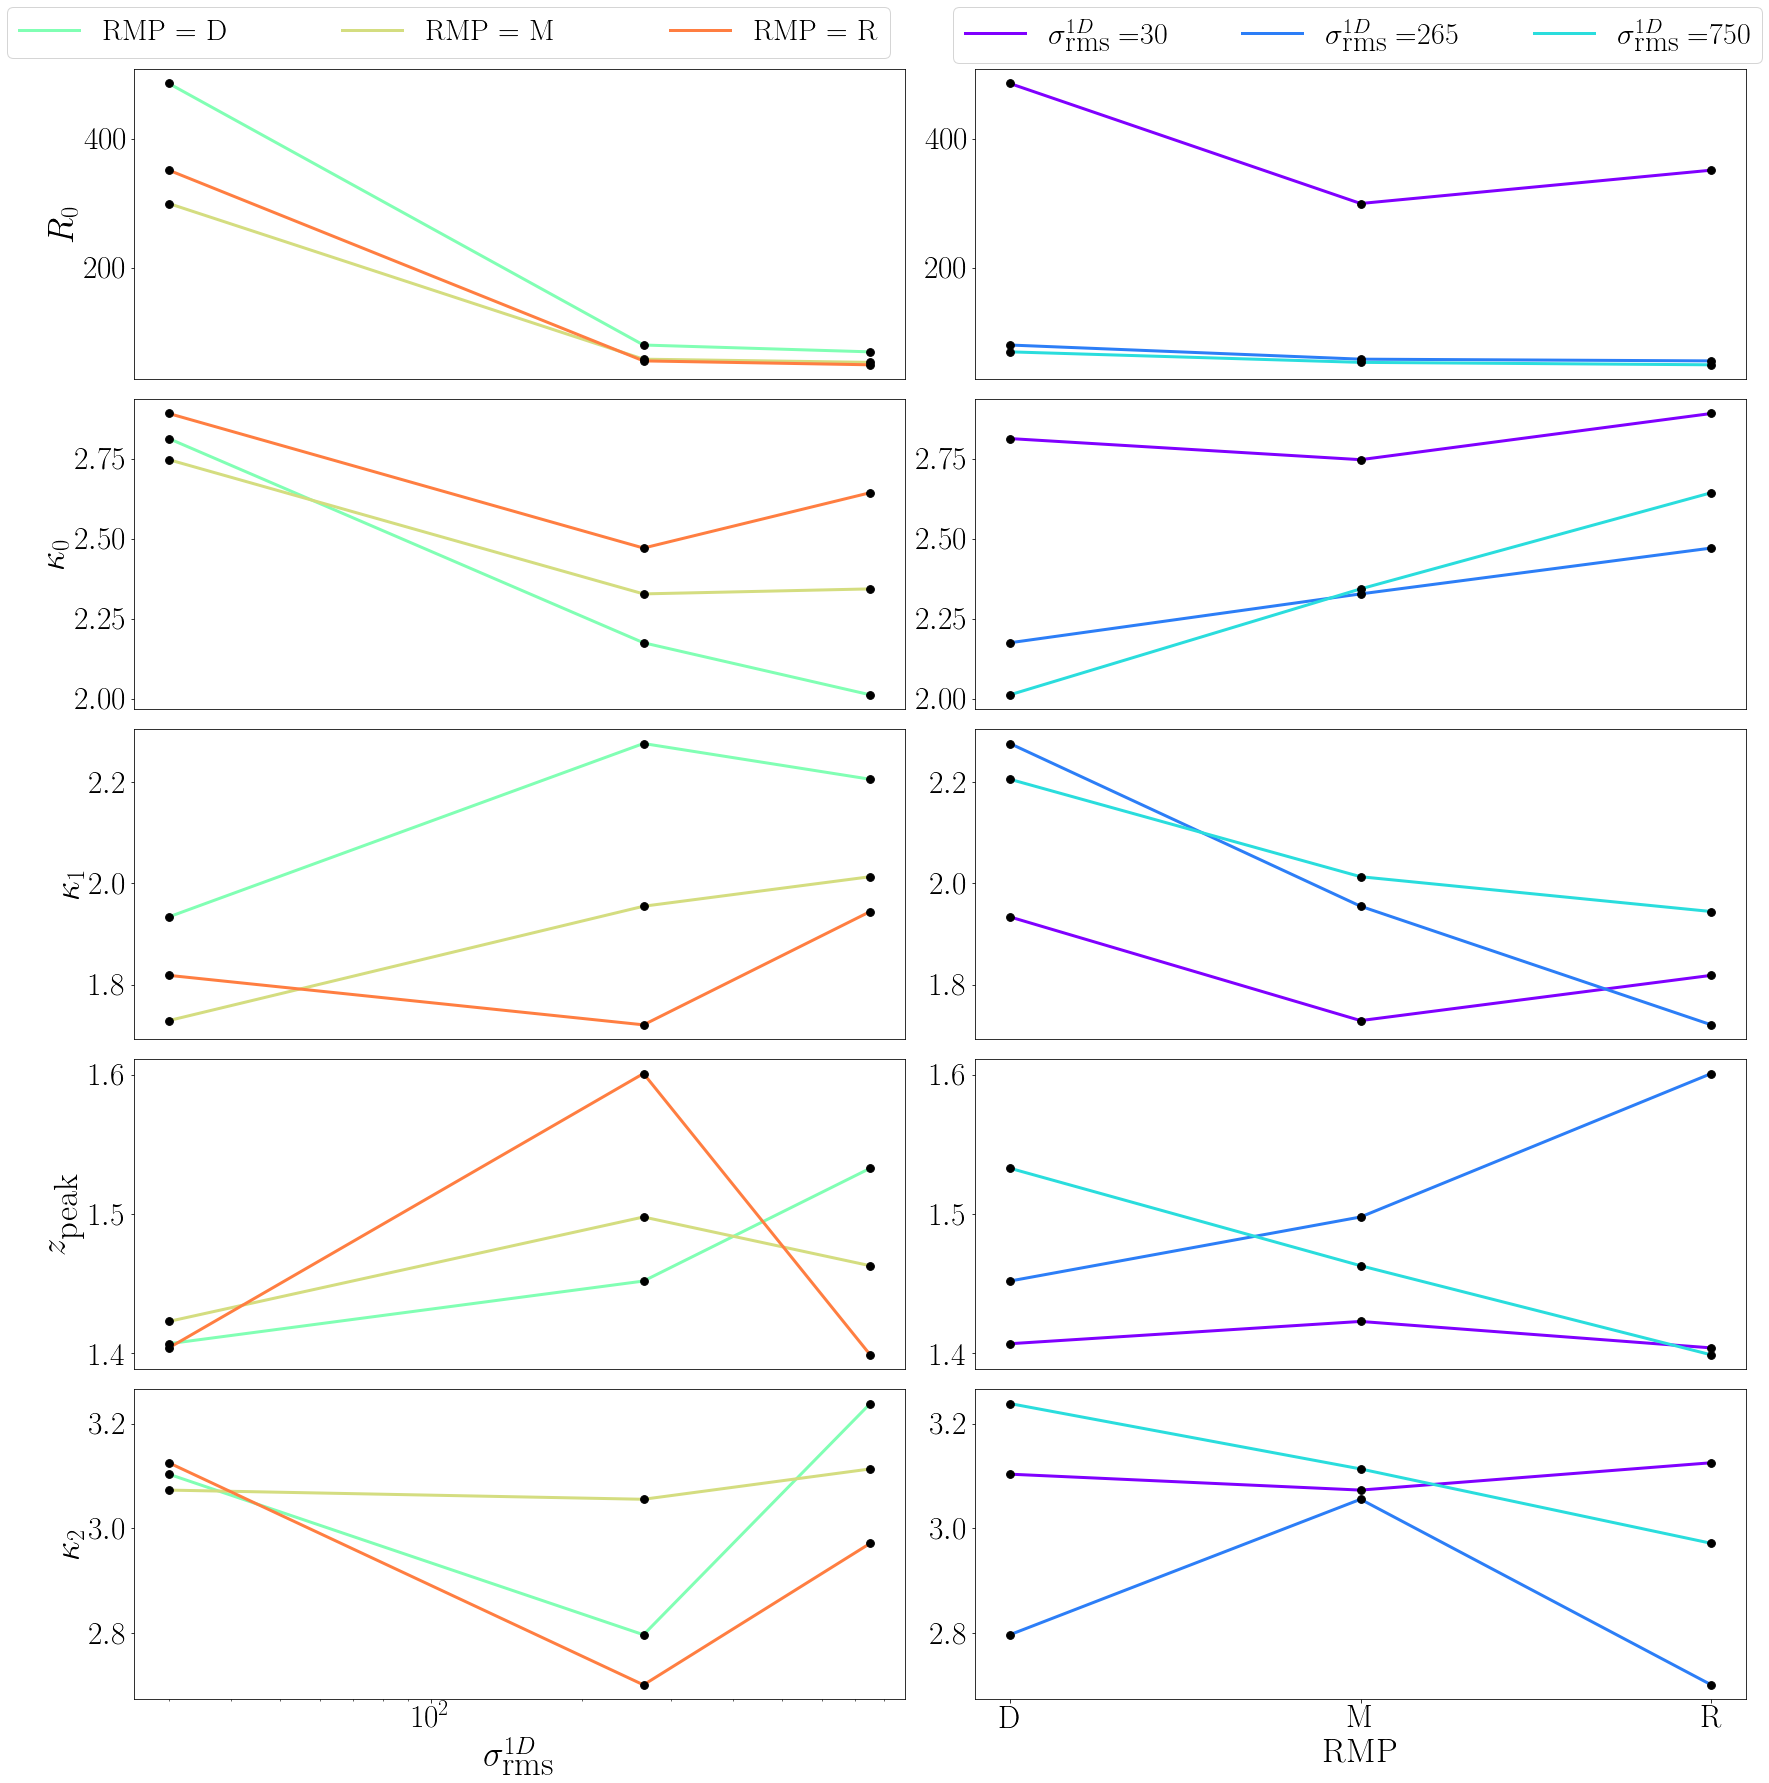

In [ ]:
plot_functions_of_params(velocity_dispersions, remnant_mass_ps, alpha_color_grid=alpha_color_grid, beta_color_grid=beta_color_grid, dco_type='BNS', lw=4, markersize=60, fs=35)

## b) BHNS

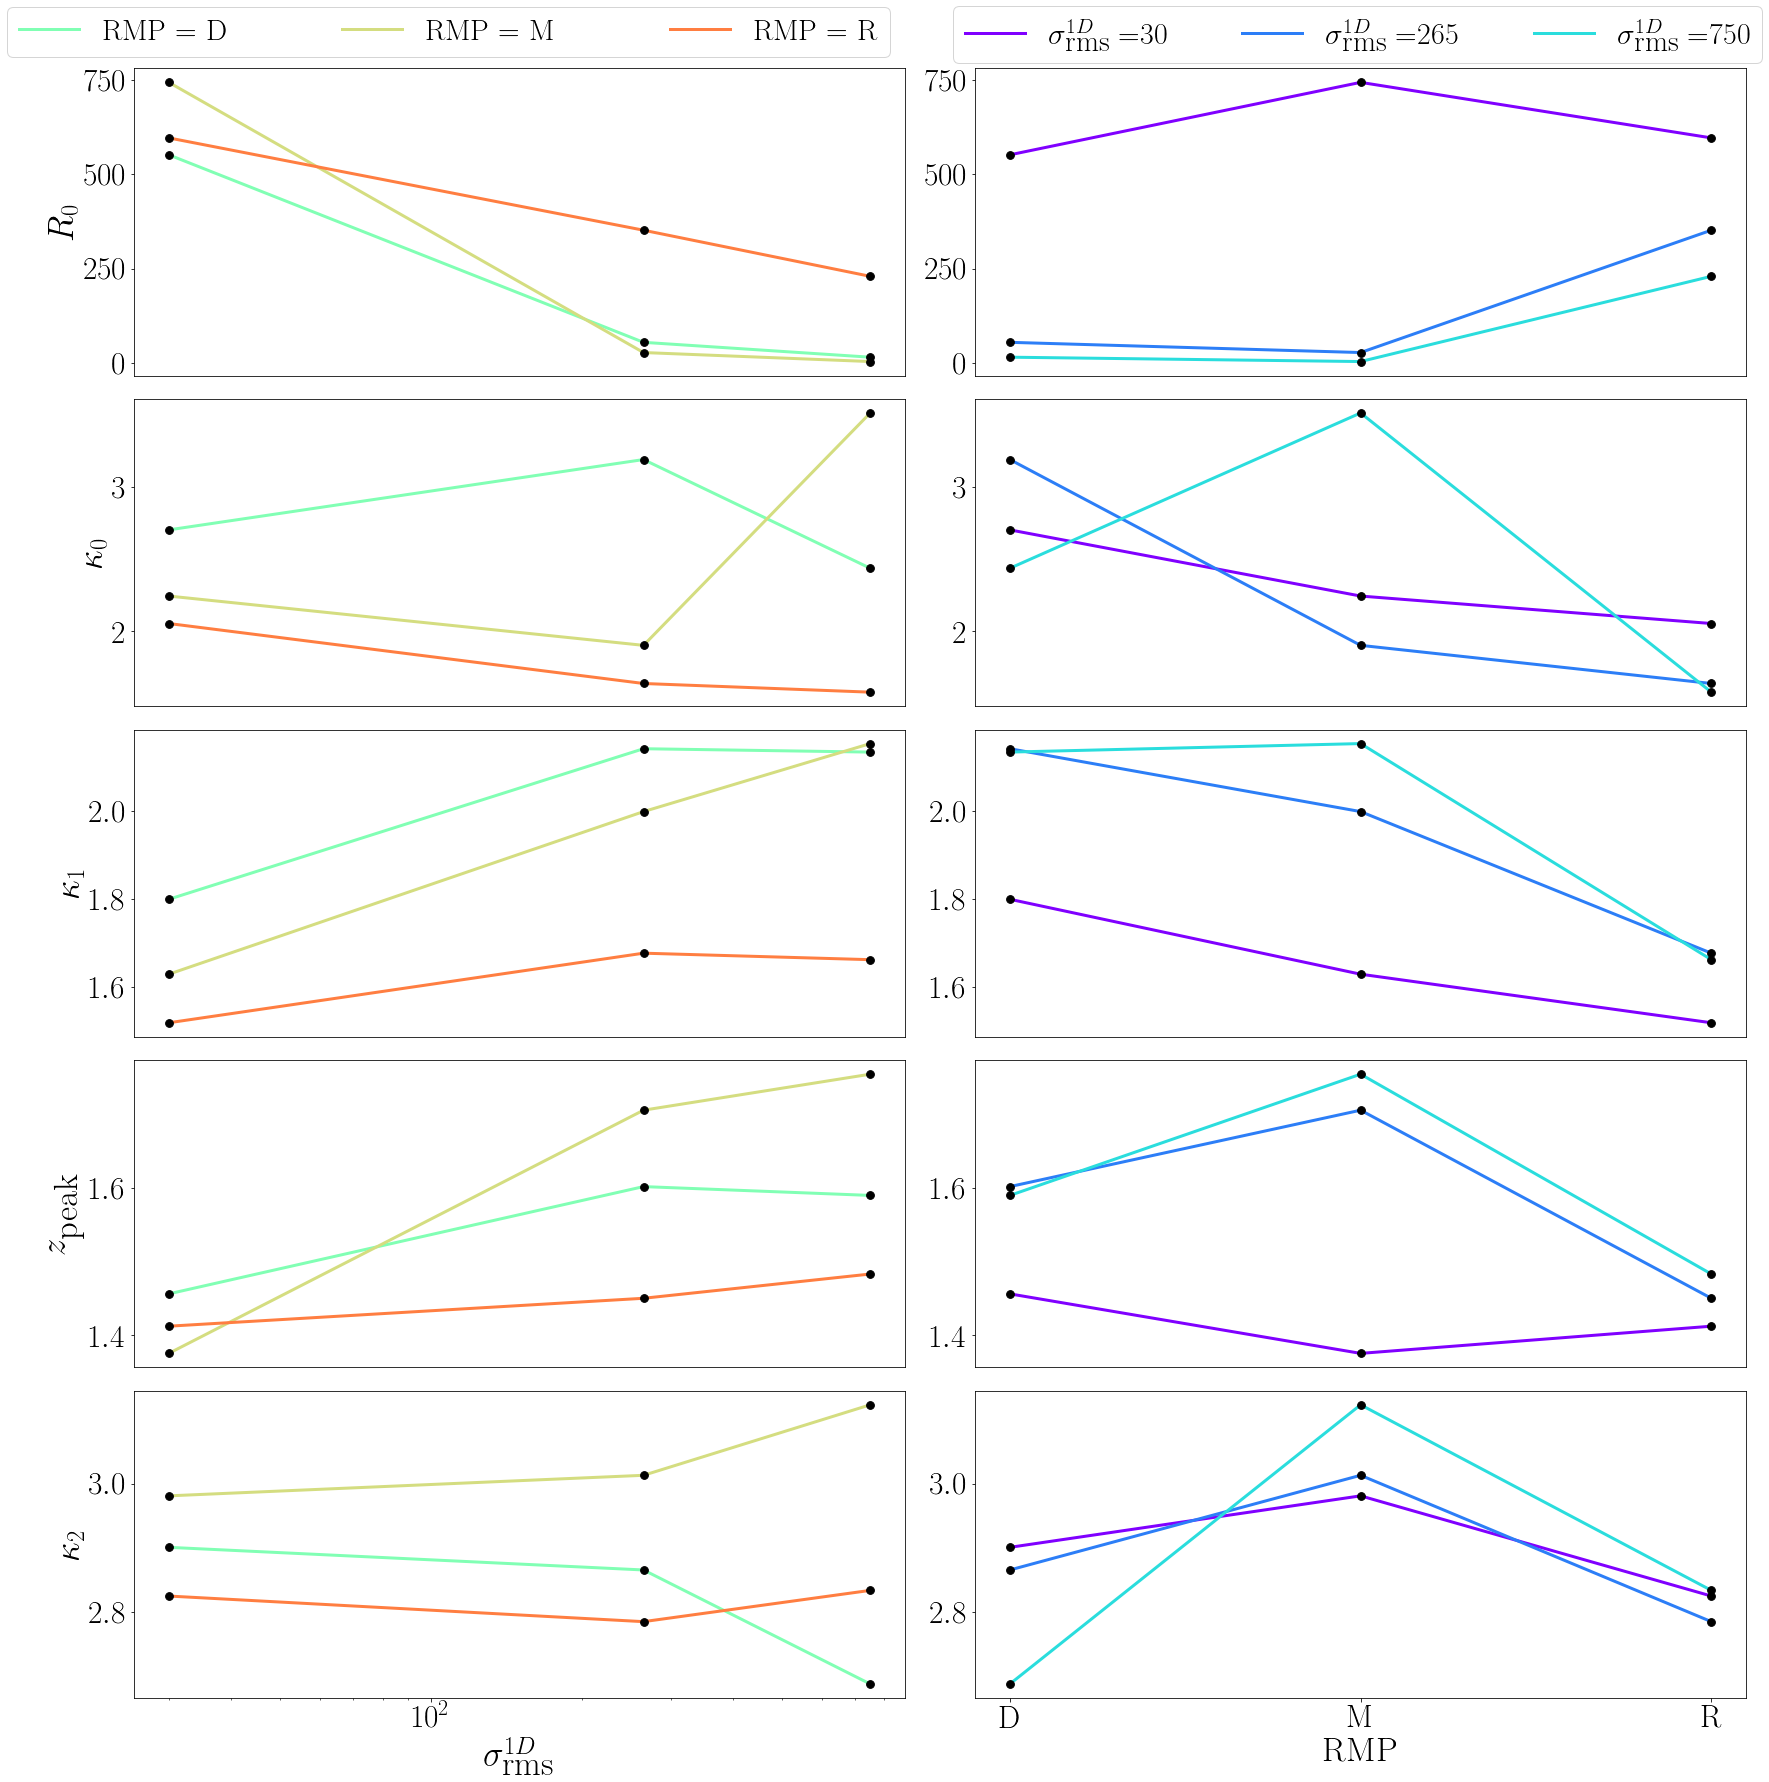

In [ ]:
plot_functions_of_params(velocity_dispersions, remnant_mass_ps, alpha_color_grid=alpha_color_grid, beta_color_grid=beta_color_grid, dco_type='BHNS', lw=4, markersize=60, fs=35)

## c) BBH

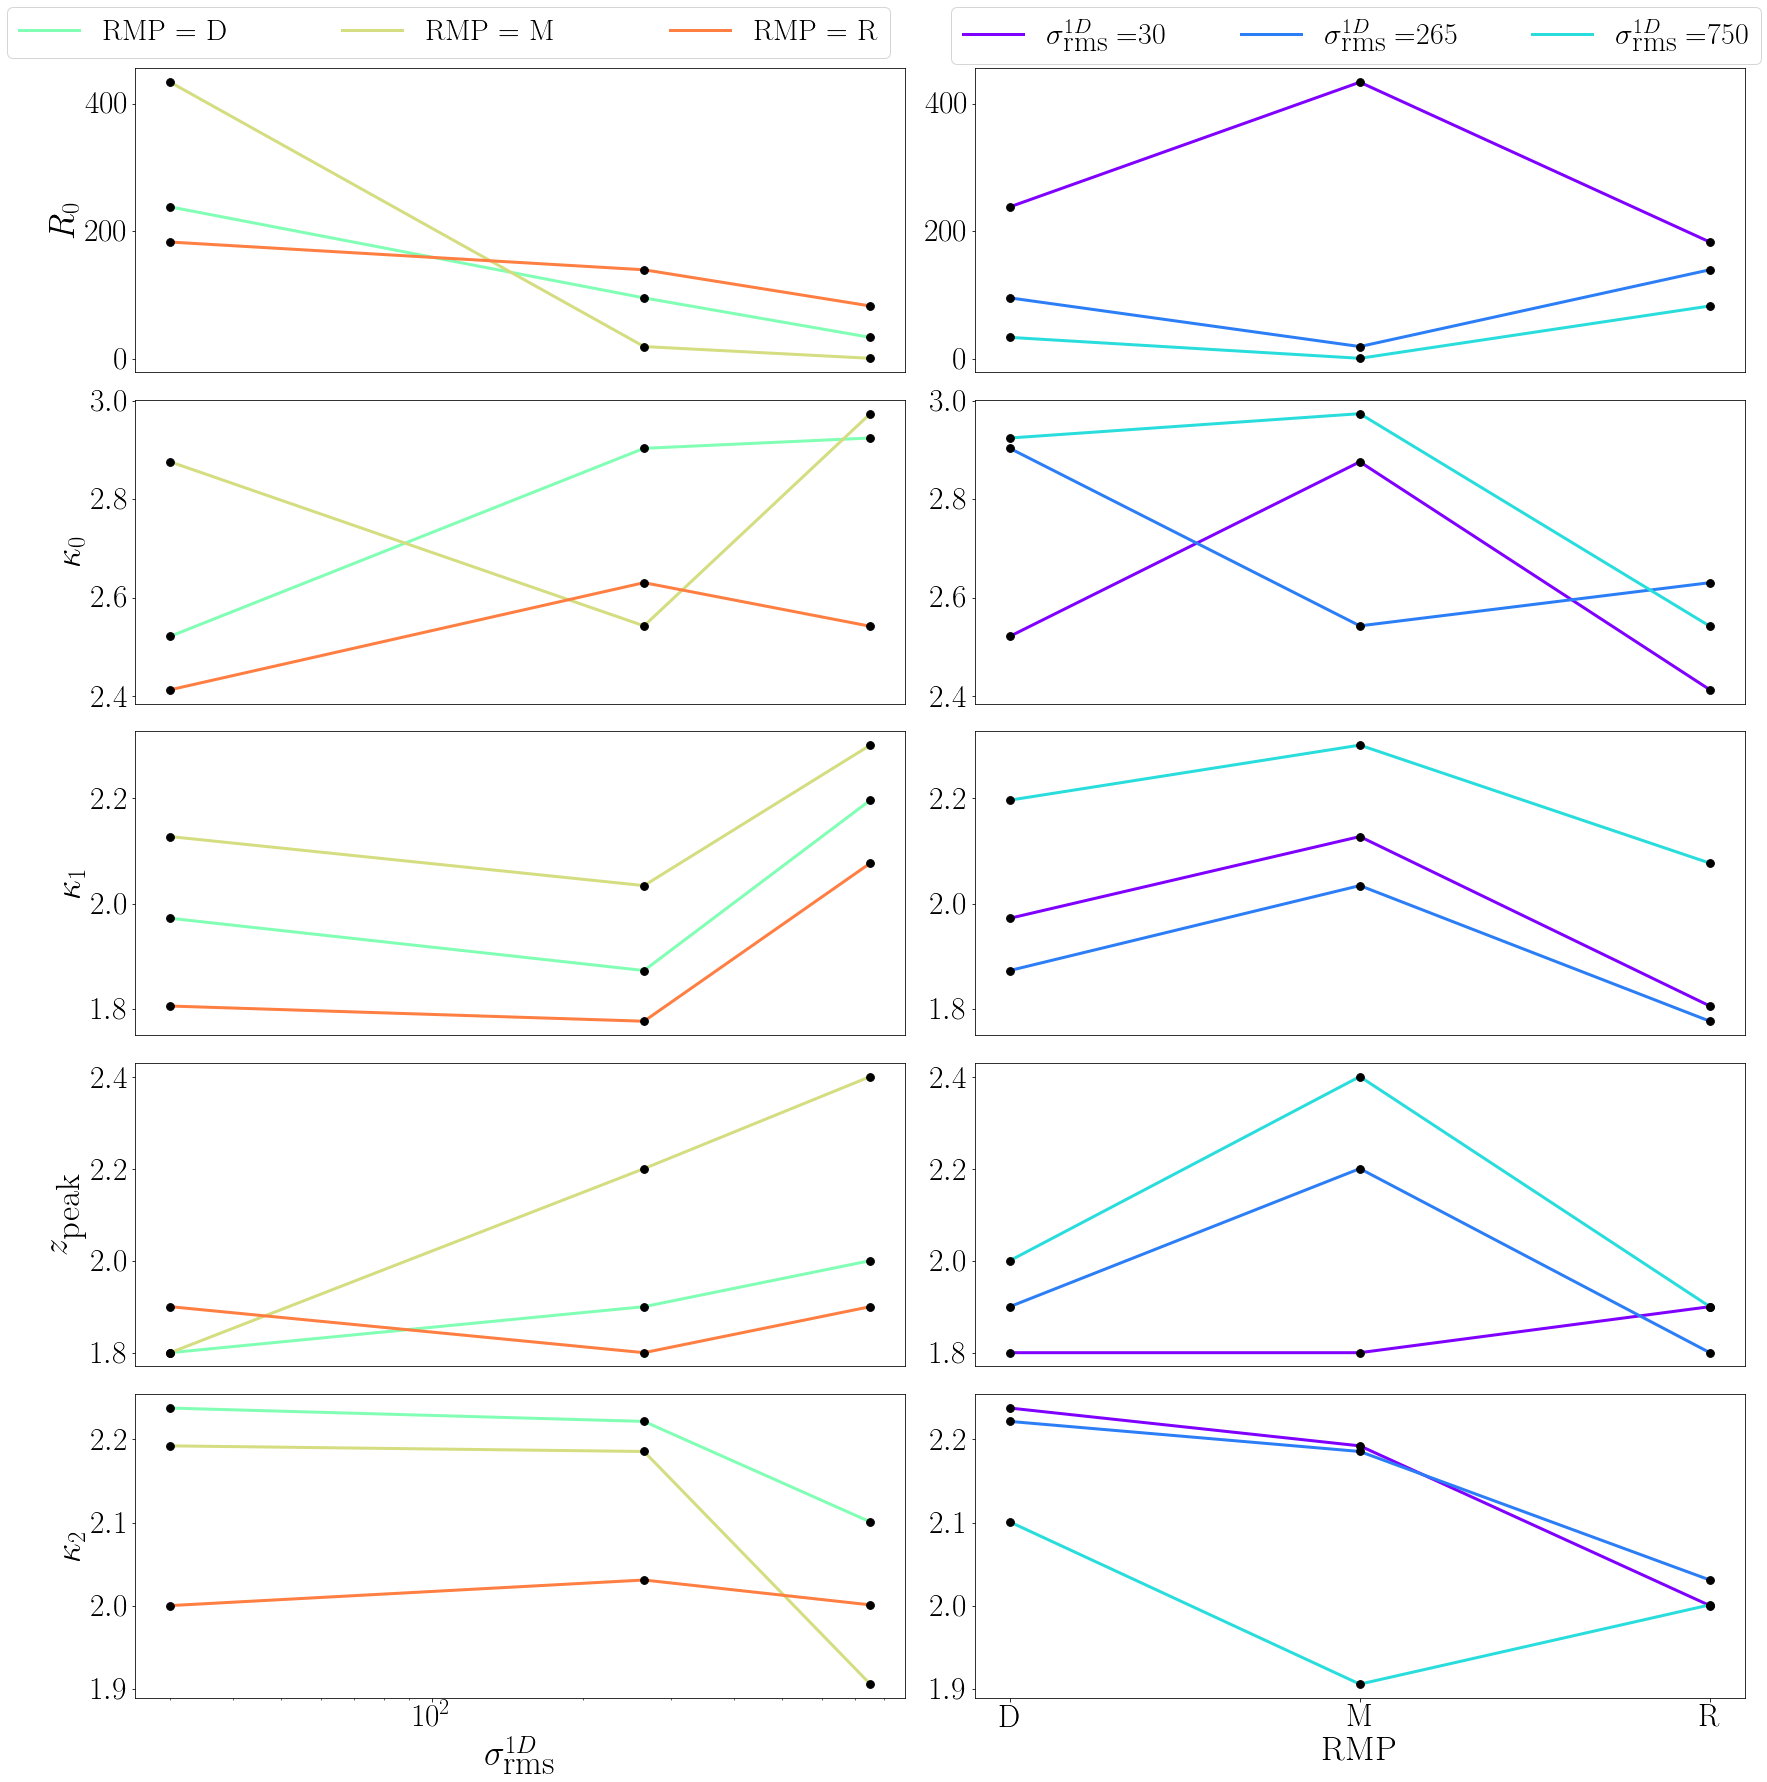

In [ ]:
plot_functions_of_params(velocity_dispersions, remnant_mass_ps, alpha_color_grid=alpha_color_grid, beta_color_grid=beta_color_grid, dco_type='BBH', lw=4, markersize=60, fs=35)

# Plot the rates but with the GWTC-3 rates

In [ ]:
redshift_PP_path = '/n/home04/aboesky/berger/Exploring_Parameter_Space/GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_redshift_data.h5'

In [ ]:
def redshift_spectrum_plot(filename, limits, condensed_paths, alpha_vals, beta_vals, dco_type=None, lw=2):
    """
    Generates a plot of the PPD and X% credible region for the merger rate as a function of redshift,
    where X=limits[1]-limits[0]
    """                                        # ADAM'S FIDUCIAL MSSFR PARAMETERS

    # CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
    #                     'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
    #                     'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
    #                     'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
    #                     'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
    #                     'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
    #                     'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
    #                     'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
    #                     'snr_max': snr_max, 'snr_step': snr_step,
    #                     'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
    #                     'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
    #                     'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
            with open('/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_sigma_remnant_prescription/output_sigma_'+alpha_val+'_remnant_prescription_'+beta_val+'/Pickled_Rates/MSSFR_111/'+dco_type+'/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    model = PowerLawRedshift(z_max=1.9)
    redshifts_ligo = model.zs_

    with open(filename, 'r') as _data:
        _data = dd.io.load(filename)
        lines = _data["lines"]
        ppd = _data["ppd"]
            
    label = 'GWTC-3'

        ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['30']['D']

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr_normalized = sfr/sfr[0]                           # Make it so the area under the curve is 1

    


    # # Include legend
    # leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, .955),  markerscale=25) 
    # for legobj in leg.legendHandles:
    #     legobj.set_linewidth(3.0)



    ax.plot(redshifts_ligo, ppd, label=label)
    ax.fill_between(
        redshifts_ligo,
        np.percentile(lines["redshift"], limits[0], axis=0),
        np.percentile(lines["redshift"], limits[1], axis=0),
        alpha=0.5,
    )

    # Plot SFRs
    ax.plot(sfr_redshifts, sfr_normalized * ppd[0], color='black', lw=3, linestyle='dashed', label=r'SFR')

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
        
            ax.plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\sigma_{\textrm{rms}}^{1D} = $' + alpha_val + r'$\textrm{ RMP} = $' + beta_val, color=color_grid[alpha_val][beta_val])
            ax.fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            ax.fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])


    # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(0.94, 2),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    ylabel = "$\\mathcal{R}(z)$ [Gpc$^{-3}$yr$^{-1}$]"
    ax.set_xlim(0, 1.5)
    ax.set_ylim(1, 5E3)
    ax.set_yscale("log")
    ax.set_xlabel("$z$", fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.tick_params(axis='both', labelsize=0.9*fs)
    # ax.legend(loc="best")
    plt.tight_layout()
    return fig

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


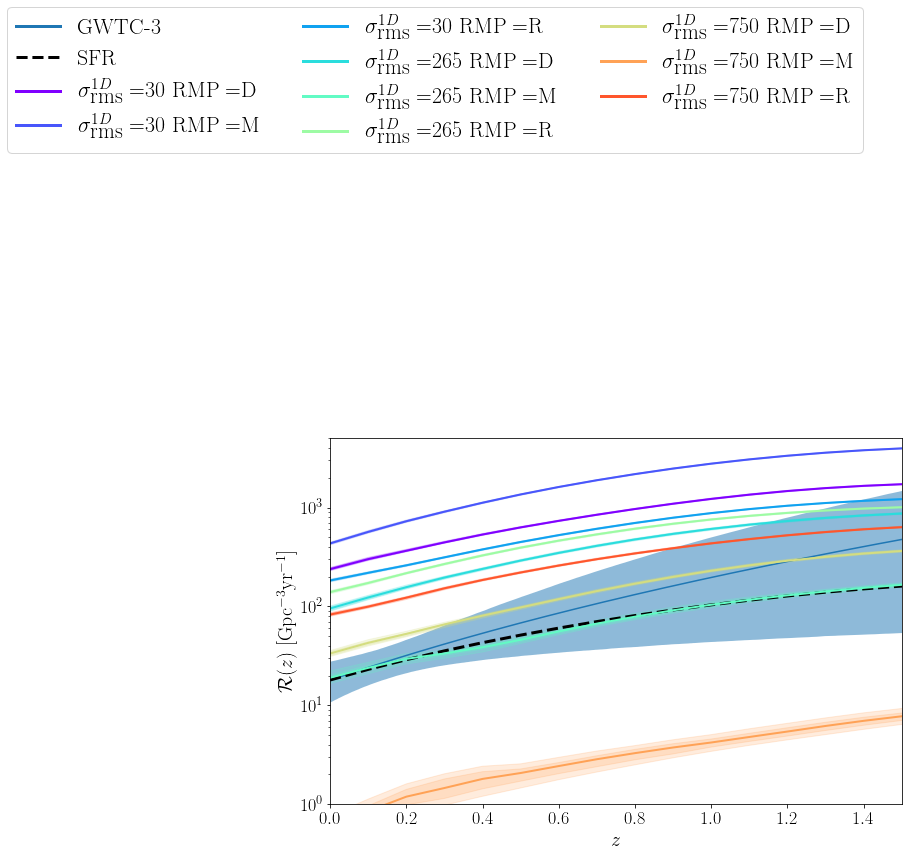

In [ ]:
redshift_fig = redshift_spectrum_plot(redshift_PP_path, limits=[5,95], condensed_paths=condensed_paths, alpha_vals=velocity_dispersions, beta_vals=remnant_mass_ps, dco_type='BBH')

In [ ]:
def get_rates_by_formation_channel(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
    channel_keys = [1,2,3,4,0]

    # Make dictionaries to put the rates in
    total_merger_rates = {}
    redshifts = {}
    data_chs = {}
    R0s = {}

    for alpha_val in alpha_vals:

        # Make sub dict for alpha value
        total_merger_rates[alpha_val] = {}
        redshifts[alpha_val] = {}
        data_chs[alpha_val] = {}
        R0s[alpha_val] = {}

        for beta_val in beta_vals:

            # Make sub dict for beta value
            total_merger_rates[alpha_val][beta_val] = {}
            redshifts[alpha_val][beta_val] = {}
            data_chs[alpha_val][beta_val] = {}

            # Get and put data into dicts
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps_by_formation_channel.h5', 'rb') as f:
                for ch_key, channel in channel_types.items():                    
                    # Get data
                    h5_data = h5.File(f)
                    try:
                        total_merger_rates[alpha_val][beta_val][channel] = h5_data[channel]['total_merger_rates'][...]
                        redshifts[alpha_val][beta_val][channel] = h5_data[channel]['redshifts'][...]
                        data_chs[alpha_val][beta_val][ch_key] = channel
                    except:
                        print('No data for alpha = ', alpha_val, ', beta = ', beta_val, 'channel: ', channel)
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                R0s[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...][0]

    return redshifts, total_merger_rates, data_chs, R0s

In [ ]:
redshifts = {}
total_merger_rates = {}
data_chs = {}
R0s = {}
for dco_type in ('BBH', 'BHNS', 'BNS'):
    redshifts[dco_type], total_merger_rates[dco_type], data_chs[dco_type], R0s[dco_type] = get_rates_by_formation_channel(condensed_paths, alpha_vals, beta_vals, dco_type=dco_type, weight_column=weight_column,
                merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
                no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
                max_redshift_detection=max_redshift_detection,
                redshift_step=redshift_step, z_first_SF=z_first_SF,
                m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
                fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
                mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
                min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
                sensitivity=sensitivity, snr_threshold=snr_threshold,
                Mc_max=Mc_max, Mc_step=Mc_step,
                eta_max=eta_max, eta_step=eta_step,
                snr_max=snr_max, snr_step=snr_step,
                lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
                panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

No data for alpha =  0.1 , beta =  0.25 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.5 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.75 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.25 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.5 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.75 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.25 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.5 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  2.0 , beta =  0.25 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  2.0 , beta =  0.5 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  10.0 , beta =  0.25 channel:  (IV) Double Core CE at 

channel:  (II) Only stable
No data for alpha =  0.1 , beta =  0.5 channel:  (III) Single core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.5 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.1 , beta =  0.75 channel:  (II) Only stable
No data for alpha =  0.1 , beta =  0.75 channel:  (III) Single core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.25 channel:  (II) Only stable
No data for alpha =  0.5 , beta =  0.25 channel:  (III) Single core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.25 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.5 channel:  (II) Only stable
No data for alpha =  0.5 , beta =  0.5 channel:  (III) Single core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.5 channel:  (IV) Double Core CE at first mass transfer
No data for alpha =  0.5 , beta =  0.75 channel:  (II) Only stable
No data for alpha =  0.5 , beta =  0.75 channel:  (III)

In [ ]:
channel_types = {1: '(I) Classic', 2: '(II) Only stable', 3: '(III) Single core CE at first mass transfer', 4: '(IV) Double Core CE at first mass transfer', 0: '(V) Other'}
cols = ['alpha_CE', 'beta', 'R0', '(I) Classic', '(II) Only stable', '(III) Single core CE at first mass transfer', '(IV) Double Core CE at first mass transfer', '(V) Other']
BBH_rate_by_channel_df = pd.DataFrame(columns=cols)
BHNS_rate_by_channel_df = pd.DataFrame(columns=cols)
BNS_rate_by_channel_df = pd.DataFrame(columns=cols)
dco_dfs = [BBH_rate_by_channel_df, BHNS_rate_by_channel_df, BNS_rate_by_channel_df]

for alpha_val in alpha_vals:
    for beta_val in beta_vals:
        for i, dco_type in enumerate(['BBH', 'BHNS', 'BNS']):

            # Get new row
            new_model = {'alpha_CE': alpha_val, 'beta': beta_val, 'R0': R0s[dco_type][alpha_val][beta_val]}
            total_rate = 0
            for ch_ind, ch in channel_types.items():
                if total_merger_rates[dco_type][alpha_val][beta_val].get(ch) is not None:
                    total_rate += total_merger_rates[dco_type][alpha_val][beta_val][ch][0]
                    new_model[ch] = [total_merger_rates[dco_type][alpha_val][beta_val][ch][0]]
                else:
                    new_model[ch] = [0]

            # Divide by total_rate to get proportion
            for ch_ind, ch in channel_types.items():
                new_model[ch][0] = new_model[ch][0] / total_rate

            # Convert the dictionary to a Series and append
            new_model = pd.DataFrame(new_model)
            dco_dfs[i] = pd.concat((dco_dfs[i], new_model), ignore_index = True)

In [ ]:
dco_dfs[0].head()

,alpha_CE,beta,R0,(I) Classic,(II) Only stable,(III) Single core CE at first mass transfer,(IV) Double Core CE at first mass transfer,(V) Other
0,0.1,0.25,71.586512,0.075107,0.418875,0.054321,0.0,0.451697
1,0.1,0.5,96.209015,0.089882,0.619209,0.033474,0.0,0.257434
2,0.1,0.75,124.177057,0.062851,0.79405,0.053251,0.0,0.089848
3,0.5,0.25,80.32091,0.085174,0.354362,0.168537,0.0,0.391927
4,0.5,0.5,108.068434,0.067707,0.546465,0.149888,0.0,0.23594


In [ ]:
xlwriter = pd.ExcelWriter('/Users/adamboesky/Desktop/intrinsic_rate_by_formation.xlsx')
dco_dfs[0].to_excel(xlwriter, sheet_name = 'BBH', index = False)
dco_dfs[1].to_excel(xlwriter, sheet_name = 'BHNS', index = False)
dco_dfs[2].to_excel(xlwriter, sheet_name = 'BNS', index = False)
xlwriter.save()